# MVPC Pipeline — Running MVPC on Synthetic Data
This notebook loads the synthetic datasets generated in `01_generate_synthetic_data.ipynb` and runs the full MVPC pipeline:
- missingness‑parent detection  
- initial skeleton extraction  
- corrected skeleton search  
- orientation of the corrected skeleton  


In [67]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: c:\Users\sofia\OneDrive\Υπολογιστής\Thesis_New


In [68]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw

# binary tests
from mvpc.ci_tests.bin_drw import bin_ci_drw
from mvpc.ci_tests.bin_permc import bin_ci_permc
from mvpc.ci_tests.bin_td import bin_ci_td  

from mvpc.missingness import detection_prt_m
from mvpc.skeleton import skeleton2


In [189]:

# 01 — Tiny Dummy Dataset Generator

def generate_dummy_gaussian_with_missing(
    n=200,
    p=5,
    missing_rate=0.2,
    seed=0,
):
    """
    Simple linear Gaussian SEM with MCAR missingness.
    Returns an (n, p) array with NaNs.
    """
    rng = np.random.default_rng(seed)

    # Random DAG-ish linear model
    W = np.zeros((p, p))
    for i in range(p):
        for j in range(i):
            if rng.random() < 0.4:
                W[i, j] = rng.normal(0.5, 0.2)

    X = np.zeros((n, p))
    noise = rng.normal(size=(n, p))

    # Topological order is 0..p-1 by construction
    for j in range(p):
        parents = np.where(W[j] != 0)[0]
        if len(parents) == 0:
            X[:, j] = noise[:, j]
        else:
            X[:, j] = X[:, parents] @ W[j, parents] + noise[:, j]

    # Inject MCAR missingness
    mask = rng.random(size=X.shape) < missing_rate
    X_missing = X.copy()
    X_missing[mask] = np.nan

    return X_missing


In [190]:
# MVPC on Dummy Dataset

dummy_data = generate_dummy_gaussian_with_missing(
    n=200,
    p=5,
    missing_rate=0.2,
    seed=42
)

print("Dummy dataset shape:", dummy_data.shape)
print("Missing values:", np.isnan(dummy_data).sum())

mvpc_dummy = MVPC(
    indep_test=gauss_ci_td,      # base CI test
    corr_test=gauss_ci_permc,    # or gauss_ci_drw
    alpha=0.05
)

res_dummy = mvpc_dummy.run(dummy_data)

print("Initial skeleton shape:", res_dummy["G_initial"].shape)
print("Corrected skeleton shape:", res_dummy["G_corrected"].shape)

res_dummy["G_corrected"]


Dummy dataset shape: (200, 5)
Missing values: 193
[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

x=0, y=1, S=[], n_after_deletion=159
x=0, y=2, S=[], n_after_deletion=158
x=0, y=3, S=[], n_after_deletion=162
x=0, y=4, S=[], n_after_deletion=167


[Step 1] R_ind=0, parents=[np.int64(3)]


x=1, y=0, S=[], n_after_deletion=161
x=1, y=2, S=[], n_after_deletion=158
x=1, y=3, S=[], n_after_deletion=162
x=1, y=4, S=[], n_after_deletion=167


[Step 1] R_ind=1, parents=[np.int64(3)]


x=2, y=0, S=[], n_after_deletion=161
x=2, y=1, S=[], n_after_deletion=159
x=2, y=3, S=[], n_after_deletion=162
x=2, y=4, S=[], n_after_deletion=167
[Step 1] R_ind=2, parents=[]


x=3, y=0, S=[], n_after_deletion=161
x=3, y=1, S=[], n_after_deletion=159
x=3, y=2, S=[], n_after_deletion=158
x=3, y=4, S=[], n_after_deletion=167


[Step 1] R_ind=3, parents=[np.int64(4)]


x=4, y=0, S=[], n_after_deletion=161
x=4, y=1, S=[], n_after_deletion=159
x=4, y=2, S=[], n_after_deletion=158
x=4, y=3, S=[], n_after_deletion=162


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 46.50it/s]


[Step 1] R_ind=4, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with β‰¥1 parent): [0, 1, 3, 4]
[Step 1] prt dict: {0: [np.int64(3)], 1: [np.int64(3)], 3: [np.int64(4)], 4: [np.int64(2)]}


x=0, y=1, S=[], n_after_deletion=128
x=0, y=2, S=[], n_after_deletion=127
x=0, y=3, S=[], n_after_deletion=129
x=0, y=4, S=[], n_after_deletion=135
x=1, y=2, S=[], n_after_deletion=125
x=1, y=3, S=[], n_after_deletion=126
x=1, y=4, S=[], n_after_deletion=135
x=2, y=3, S=[], n_after_deletion=127
x=2, y=4, S=[], n_after_deletion=131
x=3, y=4, S=[], n_after_deletion=141


x=1, y=4, S=[], n_after_deletion=135
x=2, y=4, S=[], n_after_deletion=131


Initial skeleton shape: (5, 5)
Corrected skeleton shape: (5, 5)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0]])

In [191]:

mvpc_dummy = MVPC(
    indep_test=gauss_ci_td,      # base CI test
    corr_test=gauss_ci_drw,    # or gauss_ci_drw
    alpha=0.05
)

res_dummy = mvpc_dummy.run(dummy_data)

print("Initial skeleton shape:", res_dummy["G_initial"].shape)
print("Corrected skeleton shape:", res_dummy["G_corrected"].shape)

res_dummy["G_corrected"]


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 4]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

x=0, y=1, S=[], n_after_deletion=159
x=0, y=2, S=[], n_after_deletion=158
x=0, y=3, S=[], n_after_deletion=162
x=0, y=4, S=[], n_after_deletion=167


[Step 1] R_ind=0, parents=[np.int64(3)]


x=1, y=0, S=[], n_after_deletion=161
x=1, y=2, S=[], n_after_deletion=158
x=1, y=3, S=[], n_after_deletion=162
x=1, y=4, S=[], n_after_deletion=167


[Step 1] R_ind=1, parents=[np.int64(3)]


x=2, y=0, S=[], n_after_deletion=161
x=2, y=1, S=[], n_after_deletion=159
x=2, y=3, S=[], n_after_deletion=162
x=2, y=4, S=[], n_after_deletion=167
[Step 1] R_ind=2, parents=[]


x=3, y=0, S=[], n_after_deletion=161
x=3, y=1, S=[], n_after_deletion=159
x=3, y=2, S=[], n_after_deletion=158
x=3, y=4, S=[], n_after_deletion=167


Detecting parents of missingness indicators:  80%|████████  | 4/5 [00:00<00:00, 29.47it/s]

[Step 1] R_ind=3, parents=[np.int64(4)]


x=4, y=0, S=[], n_after_deletion=161
x=4, y=1, S=[], n_after_deletion=159
x=4, y=2, S=[], n_after_deletion=158
x=4, y=3, S=[], n_after_deletion=162


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 28.95it/s]


[Step 1] R_ind=4, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with β‰¥1 parent): [0, 1, 3, 4]
[Step 1] prt dict: {0: [np.int64(3)], 1: [np.int64(3)], 3: [np.int64(4)], 4: [np.int64(2)]}


Initial skeleton, ord=0:   0%|          | 0/20 [00:00<?, ?it/s]

x=0, y=1, S=[], n_after_deletion=128
x=0, y=2, S=[], n_after_deletion=127
x=0, y=3, S=[], n_after_deletion=129
x=0, y=4, S=[], n_after_deletion=135
x=1, y=2, S=[], n_after_deletion=125
x=1, y=3, S=[], n_after_deletion=126
x=1, y=4, S=[], n_after_deletion=135
x=2, y=3, S=[], n_after_deletion=127
x=2, y=4, S=[], n_after_deletion=131
x=3, y=4, S=[], n_after_deletion=141


Corrected skeleton, ord=0:   0%|          | 0/4 [00:00<?, ?it/s]

x=1, y=4, S=[], n_after_deletion=135
x=2, y=4, S=[], n_after_deletion=131


Initial skeleton shape: (5, 5)
Corrected skeleton shape: (5, 5)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0]])

In [192]:
# Load MAR Dataset
data_mar = pd.read_csv("../data/synthetic_data_csv_files/missing_mar.csv").values 
data_mar.shape

(2000, 20)

In [193]:
# Load MNAR Dataset
data_mnar = pd.read_csv("../data/synthetic_data_csv_files/missing_mnar.csv").values 
data_mnar.shape

(2000, 20)

In [194]:

# Run MVPC on MAR / MNAR Data

mvpc = MVPC(
    indep_test=gauss_ci_td,      # base CI test ################## gauss_ci_td
    corr_test=gauss_ci_permc,    # or gauss_ci_drw
    alpha=0.05
)

res_mar = mvpc.run(data_mar)
res_mnar = mvpc.run(data_mnar)

print("MAR corrected skeleton:", res_mar["G_corrected"].shape)
print("MNAR corrected skeleton:", res_mnar["G_corrected"].shape)


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 7, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

x=1, y=0, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1265
x=1, y=3, S=[], n_after_deletion=2000
x=1, y=4, S=[], n_after_deletion=2000
x=1, y=5, S=[], n_after_deletion=979
x=1, y=6, S=[], n_after_deletion=2000
x=1, y=7, S=[], n_after_deletion=1018
x=1, y=8, S=[], n_after_deletion=2000
x=1, y=9, S=[], n_after_deletion=2000
x=1, y=10, S=[], n_after_deletion=2000
x=1, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=2000
x=1, y=13, S=[], n_after_deletion=2000
x=1, y=14, S=[], n_after_deletion=1060
x=1, y=15, S=[], n_after_deletion=2000
x=1, y=16, S=[], n_after_deletion=761
x=1, y=17, S=[], n_after_deletion=2000
x=1, y=18, S=[], n_after_deletion=2000
x=1, y=19, S=[], n_after_deletion=2000


x=1, y=4, S=[np.int64(12)], n_after_deletion=2000
x=1, y=12, S=[np.int64(4)], n_after_deletion=2000
x=1, y=12, S=[np.int64(15)], n_after_deletion=2000
x=1, y=15, S=[np.int64(4)], n_after_deletion=2000
x=1, y=15, S=[np.int64(12)], n_after_deletion=2000
x=1, y=15, S=[np.int64(19)], n_after_deletion=2000
x=1, y=19, S=[np.int64(4)], n_after_deletion=2000
x=1, y=19, S=[np.int64(12)], n_after_deletion=2000
[Step 1] R_ind=1, parents=[np.int64(15)]


x=2, y=0, S=[], n_after_deletion=2000
x=2, y=1, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=2000
x=2, y=4, S=[], n_after_deletion=2000
x=2, y=5, S=[], n_after_deletion=979
x=2, y=6, S=[], n_after_deletion=2000
x=2, y=7, S=[], n_after_deletion=1018
x=2, y=8, S=[], n_after_deletion=2000
x=2, y=9, S=[], n_after_deletion=2000
x=2, y=10, S=[], n_after_deletion=2000
x=2, y=11, S=[], n_after_deletion=2000
x=2, y=12, S=[], n_after_deletion=2000
x=2, y=13, S=[], n_after_deletion=2000
x=2, y=14, S=[], n_after_deletion=1060
x=2, y=15, S=[], n_after_deletion=2000
x=2, y=16, S=[], n_after_deletion=761
x=2, y=17, S=[], n_after_deletion=2000
x=2, y=18, S=[], n_after_deletion=2000
x=2, y=19, S=[], n_after_deletion=2000


x=2, y=3, S=[np.int64(4)], n_after_deletion=2000
x=2, y=3, S=[np.int64(6)], n_after_deletion=2000
x=2, y=3, S=[np.int64(8)], n_after_deletion=2000
x=2, y=4, S=[np.int64(3)], n_after_deletion=2000
x=2, y=6, S=[np.int64(3)], n_after_deletion=2000
x=2, y=6, S=[np.int64(4)], n_after_deletion=2000
x=2, y=6, S=[np.int64(8)], n_after_deletion=2000
x=2, y=8, S=[np.int64(3)], n_after_deletion=2000
x=2, y=8, S=[np.int64(4)], n_after_deletion=2000
x=2, y=8, S=[np.int64(6)], n_after_deletion=2000
x=2, y=8, S=[np.int64(13)], n_after_deletion=2000
x=2, y=8, S=[np.int64(17)], n_after_deletion=2000
x=2, y=8, S=[np.int64(18)], n_after_deletion=2000
x=2, y=13, S=[np.int64(3)], n_after_deletion=2000
x=2, y=13, S=[np.int64(4)], n_after_deletion=2000
x=2, y=13, S=[np.int64(6)], n_after_deletion=2000
x=2, y=13, S=[np.int64(8)], n_after_deletion=2000
x=2, y=17, S=[np.int64(3)], n_after_deletion=2000
x=2, y=17, S=[np.int64(4)], n_after_deletion=2000
x=2, y=17, S=[np.int64(6)], n_after_deletion=2000
x=2, y=18,

x=5, y=0, S=[], n_after_deletion=2000
x=5, y=1, S=[], n_after_deletion=1637
x=5, y=2, S=[], n_after_deletion=1265
x=5, y=3, S=[], n_after_deletion=2000
x=5, y=4, S=[], n_after_deletion=2000
x=5, y=6, S=[], n_after_deletion=2000
x=5, y=7, S=[], n_after_deletion=1018
x=5, y=8, S=[], n_after_deletion=2000
x=5, y=9, S=[], n_after_deletion=2000
x=5, y=10, S=[], n_after_deletion=2000
x=5, y=11, S=[], n_after_deletion=2000
x=5, y=12, S=[], n_after_deletion=2000
x=5, y=13, S=[], n_after_deletion=2000
x=5, y=14, S=[], n_after_deletion=1060
x=5, y=15, S=[], n_after_deletion=2000
x=5, y=16, S=[], n_after_deletion=761
x=5, y=17, S=[], n_after_deletion=2000
x=5, y=18, S=[], n_after_deletion=2000
x=5, y=19, S=[], n_after_deletion=2000


Detecting parents of missingness indicators:  50%|█████     | 3/6 [00:00<00:00, 26.49it/s]

x=5, y=0, S=[np.int64(4)], n_after_deletion=2000
x=5, y=0, S=[np.int64(7)], n_after_deletion=1018
x=5, y=0, S=[np.int64(11)], n_after_deletion=2000
x=5, y=0, S=[np.int64(17)], n_after_deletion=2000
x=5, y=4, S=[np.int64(0)], n_after_deletion=2000
x=5, y=7, S=[np.int64(0)], n_after_deletion=1018
x=5, y=11, S=[np.int64(0)], n_after_deletion=2000
x=5, y=17, S=[np.int64(0)], n_after_deletion=2000
x=5, y=17, S=[np.int64(4)], n_after_deletion=2000
x=5, y=17, S=[np.int64(7)], n_after_deletion=1018
[Step 1] R_ind=5, parents=[np.int64(0)]


x=7, y=0, S=[], n_after_deletion=2000
x=7, y=1, S=[], n_after_deletion=1637
x=7, y=2, S=[], n_after_deletion=1265
x=7, y=3, S=[], n_after_deletion=2000
x=7, y=4, S=[], n_after_deletion=2000
x=7, y=5, S=[], n_after_deletion=979
x=7, y=6, S=[], n_after_deletion=2000
x=7, y=8, S=[], n_after_deletion=2000
x=7, y=9, S=[], n_after_deletion=2000
x=7, y=10, S=[], n_after_deletion=2000
x=7, y=11, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=2000
x=7, y=13, S=[], n_after_deletion=2000
x=7, y=14, S=[], n_after_deletion=1060
x=7, y=15, S=[], n_after_deletion=2000
x=7, y=16, S=[], n_after_deletion=761
x=7, y=17, S=[], n_after_deletion=2000
x=7, y=18, S=[], n_after_deletion=2000
x=7, y=19, S=[], n_after_deletion=2000


x=7, y=0, S=[np.int64(1)], n_after_deletion=1637
x=7, y=0, S=[np.int64(4)], n_after_deletion=2000
x=7, y=1, S=[np.int64(0)], n_after_deletion=1637
x=7, y=1, S=[np.int64(4)], n_after_deletion=1637
x=7, y=4, S=[np.int64(0)], n_after_deletion=2000
x=7, y=4, S=[np.int64(1)], n_after_deletion=1637
x=7, y=4, S=[np.int64(5)], n_after_deletion=979
x=7, y=4, S=[np.int64(10)], n_after_deletion=2000
x=7, y=4, S=[np.int64(11)], n_after_deletion=2000
x=7, y=4, S=[np.int64(12)], n_after_deletion=2000
x=7, y=4, S=[np.int64(15)], n_after_deletion=2000
x=7, y=4, S=[np.int64(17)], n_after_deletion=2000
x=7, y=4, S=[np.int64(18)], n_after_deletion=2000
x=7, y=4, S=[np.int64(19)], n_after_deletion=2000
x=7, y=5, S=[np.int64(0)], n_after_deletion=979
x=7, y=5, S=[np.int64(1)], n_after_deletion=799
x=7, y=5, S=[np.int64(4)], n_after_deletion=979
x=7, y=10, S=[np.int64(0)], n_after_deletion=2000
x=7, y=10, S=[np.int64(1)], n_after_deletion=1637
x=7, y=10, S=[np.int64(4)], n_after_deletion=2000
x=7, y=10, S=[

x=7, y=4, S=[np.int64(11), np.int64(17)], n_after_deletion=2000
x=7, y=11, S=[np.int64(4), np.int64(17)], n_after_deletion=2000
x=7, y=17, S=[np.int64(4), np.int64(11)], n_after_deletion=2000


[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11), np.int64(17)]


x=14, y=0, S=[], n_after_deletion=2000
x=14, y=1, S=[], n_after_deletion=1637
x=14, y=2, S=[], n_after_deletion=1265
x=14, y=3, S=[], n_after_deletion=2000
x=14, y=4, S=[], n_after_deletion=2000
x=14, y=5, S=[], n_after_deletion=979
x=14, y=6, S=[], n_after_deletion=2000
x=14, y=7, S=[], n_after_deletion=1018
x=14, y=8, S=[], n_after_deletion=2000
x=14, y=9, S=[], n_after_deletion=2000
x=14, y=10, S=[], n_after_deletion=2000
x=14, y=11, S=[], n_after_deletion=2000
x=14, y=12, S=[], n_after_deletion=2000
x=14, y=13, S=[], n_after_deletion=2000
x=14, y=15, S=[], n_after_deletion=2000
x=14, y=16, S=[], n_after_deletion=761
x=14, y=17, S=[], n_after_deletion=2000
x=14, y=18, S=[], n_after_deletion=2000
x=14, y=19, S=[], n_after_deletion=2000


x=14, y=0, S=[np.int64(4)], n_after_deletion=2000
x=14, y=0, S=[np.int64(7)], n_after_deletion=1018
x=14, y=0, S=[np.int64(10)], n_after_deletion=2000
x=14, y=0, S=[np.int64(11)], n_after_deletion=2000
x=14, y=4, S=[np.int64(0)], n_after_deletion=2000
x=14, y=7, S=[np.int64(0)], n_after_deletion=1018
x=14, y=10, S=[np.int64(0)], n_after_deletion=2000
x=14, y=10, S=[np.int64(4)], n_after_deletion=2000
x=14, y=10, S=[np.int64(7)], n_after_deletion=1018
x=14, y=10, S=[np.int64(11)], n_after_deletion=2000
x=14, y=11, S=[np.int64(0)], n_after_deletion=2000
x=14, y=11, S=[np.int64(4)], n_after_deletion=2000
x=14, y=11, S=[np.int64(7)], n_after_deletion=1018
x=14, y=11, S=[np.int64(10)], n_after_deletion=2000


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


x=16, y=0, S=[], n_after_deletion=2000
x=16, y=1, S=[], n_after_deletion=1637
x=16, y=2, S=[], n_after_deletion=1265
x=16, y=3, S=[], n_after_deletion=2000
x=16, y=4, S=[], n_after_deletion=2000
x=16, y=5, S=[], n_after_deletion=979
x=16, y=6, S=[], n_after_deletion=2000
x=16, y=7, S=[], n_after_deletion=1018
x=16, y=8, S=[], n_after_deletion=2000
x=16, y=9, S=[], n_after_deletion=2000
x=16, y=10, S=[], n_after_deletion=2000
x=16, y=11, S=[], n_after_deletion=2000
x=16, y=12, S=[], n_after_deletion=2000
x=16, y=13, S=[], n_after_deletion=2000
x=16, y=14, S=[], n_after_deletion=1060
x=16, y=15, S=[], n_after_deletion=2000
x=16, y=17, S=[], n_after_deletion=2000
x=16, y=18, S=[], n_after_deletion=2000
x=16, y=19, S=[], n_after_deletion=2000


x=16, y=2, S=[np.int64(6)], n_after_deletion=1265
x=16, y=2, S=[np.int64(8)], n_after_deletion=1265
x=16, y=2, S=[np.int64(13)], n_after_deletion=1265
x=16, y=6, S=[np.int64(2)], n_after_deletion=1265
x=16, y=8, S=[np.int64(2)], n_after_deletion=1265
x=16, y=8, S=[np.int64(6)], n_after_deletion=2000
x=16, y=8, S=[np.int64(13)], n_after_deletion=2000
x=16, y=13, S=[np.int64(2)], n_after_deletion=1265
x=16, y=13, S=[np.int64(6)], n_after_deletion=2000
x=16, y=13, S=[np.int64(8)], n_after_deletion=2000


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 22.45it/s]


[Step 1] R_ind=16, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with β‰¥1 parent): [1, 2, 5, 7, 14, 16]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}


Initial skeleton, ord=0:   0%|          | 0/380 [00:00<?, ?it/s]

x=0, y=1, S=[], n_after_deletion=1637
x=0, y=2, S=[], n_after_deletion=1265
x=0, y=3, S=[], n_after_deletion=2000
x=0, y=4, S=[], n_after_deletion=2000
x=0, y=5, S=[], n_after_deletion=979
x=0, y=6, S=[], n_after_deletion=2000
x=0, y=7, S=[], n_after_deletion=1018
x=0, y=8, S=[], n_after_deletion=2000
x=0, y=9, S=[], n_after_deletion=2000
x=0, y=10, S=[], n_after_deletion=2000
x=0, y=11, S=[], n_after_deletion=2000
x=0, y=12, S=[], n_after_deletion=2000
x=0, y=13, S=[], n_after_deletion=2000
x=0, y=14, S=[], n_after_deletion=1060
x=0, y=15, S=[], n_after_deletion=2000
x=0, y=16, S=[], n_after_deletion=761
x=0, y=17, S=[], n_after_deletion=2000
x=0, y=18, S=[], n_after_deletion=2000
x=0, y=19, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1032
x=1, y=3, S=[], n_after_deletion=1637
x=1, y=4, S=[], n_after_deletion=1637
x=1, y=5, S=[], n_after_deletion=799
x=1, y=6, S=[], n_after_deletion=1637
x=1, y=7, S=[], n_after_deletion=879
x=1, y=8, S=[], n_after_deletion=1637
x=1, y

Initial skeleton, ord=0:  75%|███████▌  | 285/380 [00:00<00:00, 2836.12it/s]

x=11, y=19, S=[], n_after_deletion=2000
x=12, y=13, S=[], n_after_deletion=2000
x=12, y=14, S=[], n_after_deletion=1060
x=12, y=15, S=[], n_after_deletion=2000
x=12, y=16, S=[], n_after_deletion=761
x=12, y=17, S=[], n_after_deletion=2000
x=12, y=18, S=[], n_after_deletion=2000
x=12, y=19, S=[], n_after_deletion=2000
x=13, y=14, S=[], n_after_deletion=1060
x=13, y=15, S=[], n_after_deletion=2000
x=13, y=16, S=[], n_after_deletion=761
x=13, y=17, S=[], n_after_deletion=2000
x=13, y=18, S=[], n_after_deletion=2000
x=13, y=19, S=[], n_after_deletion=2000
x=14, y=15, S=[], n_after_deletion=1060
x=14, y=16, S=[], n_after_deletion=395
x=14, y=17, S=[], n_after_deletion=1060
x=14, y=18, S=[], n_after_deletion=1060
x=14, y=19, S=[], n_after_deletion=1060


x=15, y=16, S=[], n_after_deletion=761
x=15, y=17, S=[], n_after_deletion=2000
x=15, y=18, S=[], n_after_deletion=2000
x=15, y=19, S=[], n_after_deletion=2000
x=16, y=17, S=[], n_after_deletion=761
x=16, y=18, S=[], n_after_deletion=761
x=16, y=19, S=[], n_after_deletion=761
x=17, y=18, S=[], n_after_deletion=2000
x=17, y=19, S=[], n_after_deletion=2000
x=18, y=19, S=[], n_after_deletion=2000


Initial skeleton, ord=1:   0%|          | 0/88 [00:00<?, ?it/s]

x=0, y=4, S=[7], n_after_deletion=1018
x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=1, y=4, S=[12], n_after_deletion=1637
x=1, y=12, S=[15], n_after_deletion=1637
x=1, y=12, S=[19], n_after_deletion=1637
x=1, y=15, S=[12], n_after_deletion=1637
x=1, y=15, S=[19], n_after_deletion=1637
x=1, y=19, S=[12], n_after_deletion=1637
x=2, y=3, S=[6], n_after_deletion=1265
x=2, y=3, S=[8], n_after_deletion=1265
x=2, y=3, S=[17], n_after_deletion=1265
x=2, y=3, S=[18], n_after_deletion=1265
x=2, y=6, S=[3], n_after_deletion=1265
x=2, y=6, S=[8], n_after_deletion=1265
x=2, y=6, S=[17], n_after_deletion=1265
x=2, y=6, S=[18], n_after_deletion=1265
x=2, y=8, S=[3], n_after_deletion=1265
x=2, y=8, S=[6], n_after_deletion=1265
x=2, y=8, S=[17], n_after_deletion=1265
x=2, y=8, S=[18], n_after_deletion=1265
x=2, y=17, S=[3], n_after_deletion=1265
x=2, y=18, S=[3], n_after_deletion=1265
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[8], n_after_deletion=2000
x=3,

x=7, y=19, S=[0], n_after_deletion=1018
x=7, y=19, S=[4], n_after_deletion=1018
x=7, y=19, S=[12], n_after_deletion=1018
x=8, y=13, S=[2], n_after_deletion=1265
x=8, y=13, S=[3], n_after_deletion=2000
x=8, y=13, S=[6], n_after_deletion=2000
x=8, y=13, S=[16], n_after_deletion=761
x=8, y=13, S=[17], n_after_deletion=2000
x=8, y=13, S=[18], n_after_deletion=2000
x=8, y=16, S=[2], n_after_deletion=416
x=8, y=17, S=[2], n_after_deletion=1265
x=8, y=17, S=[3], n_after_deletion=2000
x=8, y=17, S=[6], n_after_deletion=2000
x=8, y=18, S=[2], n_after_deletion=1265
x=8, y=18, S=[3], n_after_deletion=2000
x=12, y=15, S=[1], n_after_deletion=1637
x=12, y=15, S=[4], n_after_deletion=2000
x=12, y=15, S=[7], n_after_deletion=1018
x=12, y=15, S=[19], n_after_deletion=2000
x=12, y=19, S=[1], n_after_deletion=1637
x=12, y=19, S=[4], n_after_deletion=2000
x=12, y=19, S=[7], n_after_deletion=1018
x=12, y=19, S=[15], n_after_deletion=2000
x=13, y=16, S=[6], n_after_deletion=761
x=13, y=16, S=[8], n_after_d

Initial skeleton, ord=2:   0%|          | 0/50 [00:00<?, ?it/s]

x=2, y=3, S=[6, 8], n_after_deletion=1265
x=2, y=6, S=[3, 8], n_after_deletion=1265
x=3, y=6, S=[2, 8], n_after_deletion=1265
x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=6, S=[8, 18], n_after_deletion=2000
x=3, y=8, S=[2, 6], n_after_deletion=1265
x=3, y=8, S=[2, 18], n_after_deletion=1265
x=3, y=8, S=[6, 18], n_after_deletion=2000
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=3, y=18, S=[2, 8], n_after_deletion=1265
x=3, y=18, S=[6, 8], n_after_deletion=2000
x=4, y=7, S=[12, 18], n_after_deletion=1018
x=4, y=7, S=[12, 19], n_after_deletion=1018
x=4, y=7, S=[18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18], n_after_deletion=1018
x=4, y=12, S=[7, 19], n_after_deletion=1018
x=4, y=12, S=[18, 19], n_after_deletion=2000
x=4, y=18, S=[7, 12], n_after_deletion=1018
x=4, y=18, S=[7, 19], n_after_deletion=1018
x=4, y=18, S=[12, 19], n_after_deletion=2000
x=4, y=19, S=[7, 12], n_after_deletion=1018
x=4, y=19, S=[7, 18], n_after_deletion=1018
x=4, y=19, S=[12, 18], n_after_deletion=2000


Initial skeleton, ord=3:   0%|          | 0/46 [00:00<?, ?it/s]

x=3, y=6, S=[2, 8, 18], n_after_deletion=1265
x=3, y=8, S=[2, 6, 18], n_after_deletion=1265
x=3, y=18, S=[2, 6, 8], n_after_deletion=1265
x=4, y=7, S=[12, 18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18, 19], n_after_deletion=1018
x=4, y=18, S=[7, 12, 19], n_after_deletion=1018
x=4, y=19, S=[7, 12, 18], n_after_deletion=1018
x=8, y=13, S=[2, 3, 6], n_after_deletion=1265
x=12, y=15, S=[1, 4, 7], n_after_deletion=879
x=12, y=15, S=[1, 4, 19], n_after_deletion=1637
x=12, y=15, S=[1, 7, 19], n_after_deletion=879
x=12, y=15, S=[4, 7, 19], n_after_deletion=1018
x=12, y=19, S=[1, 4, 7], n_after_deletion=879
x=12, y=19, S=[1, 4, 15], n_after_deletion=1637
x=12, y=19, S=[1, 7, 15], n_after_deletion=879
x=12, y=19, S=[4, 7, 15], n_after_deletion=1018


x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=879
x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=879


Corrected skeleton, ord=0:   0%|          | 0/46 [00:00<?, ?it/s]

x=0, y=7, S=[], n_after_deletion=1018
x=0, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=1265
x=2, y=8, S=[], n_after_deletion=1265
x=3, y=6, S=[], n_after_deletion=2000
x=3, y=8, S=[], n_after_deletion=2000
x=3, y=18, S=[], n_after_deletion=2000
x=4, y=7, S=[], n_after_deletion=1018
x=4, y=12, S=[], n_after_deletion=2000
x=4, y=18, S=[], n_after_deletion=2000
x=4, y=19, S=[], n_after_deletion=2000
x=5, y=19, S=[], n_after_deletion=979
x=6, y=8, S=[], n_after_deletion=2000
x=6, y=17, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=1018


x=8, y=13, S=[], n_after_deletion=2000
x=9, y=15, S=[], n_after_deletion=2000
x=10, y=11, S=[], n_after_deletion=2000
x=12, y=15, S=[], n_after_deletion=2000
x=12, y=19, S=[], n_after_deletion=2000
x=13, y=16, S=[], n_after_deletion=761
x=16, y=18, S=[], n_after_deletion=761


Corrected skeleton, ord=1:   0%|          | 0/46 [00:00<?, ?it/s]

x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=2, y=3, S=[8], n_after_deletion=1265
x=2, y=8, S=[3], n_after_deletion=1265
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[8], n_after_deletion=2000
x=3, y=6, S=[18], n_after_deletion=2000
x=3, y=8, S=[2], n_after_deletion=1265
x=3, y=8, S=[6], n_after_deletion=2000
x=3, y=8, S=[18], n_after_deletion=2000
x=3, y=18, S=[2], n_after_deletion=1265
x=3, y=18, S=[6], n_after_deletion=2000
x=3, y=18, S=[8], n_after_deletion=2000


Corrected skeleton, ord=1:  28%|██▊       | 13/46 [00:00<00:00, 125.43it/s]

x=4, y=7, S=[12], n_after_deletion=1018
x=4, y=7, S=[18], n_after_deletion=1018
x=4, y=7, S=[19], n_after_deletion=1018
x=4, y=12, S=[7], n_after_deletion=1018
x=4, y=12, S=[18], n_after_deletion=2000
x=4, y=12, S=[19], n_after_deletion=2000
x=4, y=18, S=[7], n_after_deletion=1018
x=4, y=18, S=[12], n_after_deletion=2000
x=4, y=18, S=[19], n_after_deletion=2000
x=4, y=19, S=[7], n_after_deletion=1018
x=4, y=19, S=[12], n_after_deletion=2000
x=4, y=19, S=[18], n_after_deletion=2000
x=6, y=8, S=[3], n_after_deletion=2000
x=6, y=8, S=[17], n_after_deletion=2000
x=6, y=17, S=[3], n_after_deletion=2000
x=6, y=17, S=[8], n_after_deletion=2000
x=7, y=12, S=[0], n_after_deletion=1018
x=7, y=12, S=[4], n_after_deletion=1018
x=8, y=13, S=[2], n_after_deletion=1265
x=8, y=13, S=[3], n_after_deletion=2000
x=8, y=13, S=[6], n_after_deletion=2000
x=12, y=15, S=[1], n_after_deletion=1637
x=12, y=15, S=[4], n_after_deletion=2000
x=12, y=15, S=[7], n_after_deletion=1018
x=12, y=15, S=[19], n_after_dele

x=12, y=19, S=[7], n_after_deletion=1018
x=12, y=19, S=[15], n_after_deletion=2000
x=13, y=16, S=[8], n_after_deletion=761
x=16, y=18, S=[13], n_after_deletion=761


Corrected skeleton, ord=2:   0%|          | 0/46 [00:00<?, ?it/s]

x=3, y=6, S=[2, 8], n_after_deletion=1265
x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=6, S=[8, 18], n_after_deletion=2000
x=3, y=8, S=[2, 6], n_after_deletion=1265
x=3, y=8, S=[2, 18], n_after_deletion=1265
x=3, y=8, S=[6, 18], n_after_deletion=2000
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=3, y=18, S=[2, 8], n_after_deletion=1265
x=3, y=18, S=[6, 8], n_after_deletion=2000
x=4, y=7, S=[12, 18], n_after_deletion=1018
x=4, y=7, S=[12, 19], n_after_deletion=1018
x=4, y=7, S=[18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18], n_after_deletion=1018
x=4, y=12, S=[7, 19], n_after_deletion=1018
x=4, y=12, S=[18, 19], n_after_deletion=2000
x=4, y=18, S=[7, 12], n_after_deletion=1018
x=4, y=18, S=[7, 19], n_after_deletion=1018
x=4, y=18, S=[12, 19], n_after_deletion=2000
x=4, y=19, S=[7, 12], n_after_deletion=1018
x=4, y=19, S=[7, 18], n_after_deletion=1018
x=4, y=19, S=[12, 18], n_after_deletion=2000
x=6, y=8, S=[3, 17], n_after_deletion=2000
x=6, y=17, S=[3, 8], n_after_deletion=200

x=12, y=19, S=[1, 15], n_after_deletion=1637
x=12, y=19, S=[4, 7], n_after_deletion=1018
x=12, y=19, S=[4, 15], n_after_deletion=2000
x=12, y=19, S=[7, 15], n_after_deletion=1018


Corrected skeleton, ord=3:   0%|          | 0/46 [00:00<?, ?it/s]

x=3, y=6, S=[2, 8, 18], n_after_deletion=1265
x=3, y=8, S=[2, 6, 18], n_after_deletion=1265
x=3, y=18, S=[2, 6, 8], n_after_deletion=1265
x=4, y=7, S=[12, 18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18, 19], n_after_deletion=1018
x=4, y=18, S=[7, 12, 19], n_after_deletion=1018
x=4, y=19, S=[7, 12, 18], n_after_deletion=1018
x=8, y=13, S=[2, 3, 6], n_after_deletion=1265
x=12, y=15, S=[1, 4, 7], n_after_deletion=879
x=12, y=15, S=[1, 4, 19], n_after_deletion=1637
x=12, y=15, S=[1, 7, 19], n_after_deletion=879
x=12, y=15, S=[4, 7, 19], n_after_deletion=1018
x=12, y=19, S=[1, 4, 7], n_after_deletion=879
x=12, y=19, S=[1, 4, 15], n_after_deletion=1637
x=12, y=19, S=[1, 7, 15], n_after_deletion=879
x=12, y=19, S=[4, 7, 15], n_after_deletion=1018


Corrected skeleton, ord=4:   0%|          | 0/46 [00:00<?, ?it/s]

x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=879


x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=879


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 8, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

x=1, y=0, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1265
x=1, y=3, S=[], n_after_deletion=2000
x=1, y=4, S=[], n_after_deletion=750
x=1, y=5, S=[], n_after_deletion=2000
x=1, y=6, S=[], n_after_deletion=2000
x=1, y=7, S=[], n_after_deletion=1018
x=1, y=8, S=[], n_after_deletion=995
x=1, y=9, S=[], n_after_deletion=2000
x=1, y=10, S=[], n_after_deletion=2000
x=1, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=2000
x=1, y=13, S=[], n_after_deletion=2000
x=1, y=14, S=[], n_after_deletion=2000
x=1, y=15, S=[], n_after_deletion=992
x=1, y=16, S=[], n_after_deletion=2000
x=1, y=17, S=[], n_after_deletion=2000
x=1, y=18, S=[], n_after_deletion=2000
x=1, y=19, S=[], n_after_deletion=2000


x=1, y=4, S=[np.int64(12)], n_after_deletion=750
x=1, y=12, S=[np.int64(4)], n_after_deletion=750
x=1, y=12, S=[np.int64(15)], n_after_deletion=992
x=1, y=15, S=[np.int64(4)], n_after_deletion=393
x=1, y=15, S=[np.int64(12)], n_after_deletion=992
x=1, y=15, S=[np.int64(19)], n_after_deletion=992
x=1, y=19, S=[np.int64(4)], n_after_deletion=750
x=1, y=19, S=[np.int64(12)], n_after_deletion=2000
[Step 1] R_ind=1, parents=[np.int64(15)]


x=2, y=0, S=[], n_after_deletion=2000
x=2, y=1, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=2000
x=2, y=4, S=[], n_after_deletion=750
x=2, y=5, S=[], n_after_deletion=2000
x=2, y=6, S=[], n_after_deletion=2000
x=2, y=7, S=[], n_after_deletion=1018
x=2, y=8, S=[], n_after_deletion=995
x=2, y=9, S=[], n_after_deletion=2000
x=2, y=10, S=[], n_after_deletion=2000
x=2, y=11, S=[], n_after_deletion=2000
x=2, y=12, S=[], n_after_deletion=2000
x=2, y=13, S=[], n_after_deletion=2000
x=2, y=14, S=[], n_after_deletion=2000
x=2, y=15, S=[], n_after_deletion=992
x=2, y=16, S=[], n_after_deletion=2000
x=2, y=17, S=[], n_after_deletion=2000
x=2, y=18, S=[], n_after_deletion=2000
x=2, y=19, S=[], n_after_deletion=2000


x=2, y=3, S=[np.int64(6)], n_after_deletion=2000
x=2, y=3, S=[np.int64(8)], n_after_deletion=995
x=2, y=6, S=[np.int64(3)], n_after_deletion=2000
x=2, y=6, S=[np.int64(8)], n_after_deletion=995
x=2, y=8, S=[np.int64(3)], n_after_deletion=995
x=2, y=8, S=[np.int64(6)], n_after_deletion=995
x=2, y=8, S=[np.int64(13)], n_after_deletion=995
x=2, y=8, S=[np.int64(16)], n_after_deletion=995
x=2, y=8, S=[np.int64(17)], n_after_deletion=995
x=2, y=8, S=[np.int64(18)], n_after_deletion=995
x=2, y=13, S=[np.int64(3)], n_after_deletion=2000
x=2, y=13, S=[np.int64(6)], n_after_deletion=2000
x=2, y=13, S=[np.int64(8)], n_after_deletion=995
x=2, y=16, S=[np.int64(3)], n_after_deletion=2000
x=2, y=16, S=[np.int64(6)], n_after_deletion=2000
x=2, y=17, S=[np.int64(3)], n_after_deletion=2000
x=2, y=17, S=[np.int64(6)], n_after_deletion=2000
x=2, y=18, S=[np.int64(3)], n_after_deletion=2000


[Step 1] R_ind=2, parents=[np.int64(8)]


x=4, y=0, S=[], n_after_deletion=2000
x=4, y=1, S=[], n_after_deletion=1637
x=4, y=2, S=[], n_after_deletion=1265
x=4, y=3, S=[], n_after_deletion=2000
x=4, y=5, S=[], n_after_deletion=2000
x=4, y=6, S=[], n_after_deletion=2000
x=4, y=7, S=[], n_after_deletion=1018
x=4, y=8, S=[], n_after_deletion=995
x=4, y=9, S=[], n_after_deletion=2000
x=4, y=10, S=[], n_after_deletion=2000
x=4, y=11, S=[], n_after_deletion=2000
x=4, y=12, S=[], n_after_deletion=2000
x=4, y=13, S=[], n_after_deletion=2000
x=4, y=14, S=[], n_after_deletion=2000
x=4, y=15, S=[], n_after_deletion=992
x=4, y=16, S=[], n_after_deletion=2000
x=4, y=17, S=[], n_after_deletion=2000
x=4, y=18, S=[], n_after_deletion=2000
x=4, y=19, S=[], n_after_deletion=2000


x=4, y=11, S=[np.int64(13)], n_after_deletion=2000
x=4, y=11, S=[np.int64(16)], n_after_deletion=2000
x=4, y=13, S=[np.int64(11)], n_after_deletion=2000
x=4, y=13, S=[np.int64(16)], n_after_deletion=2000
x=4, y=16, S=[np.int64(11)], n_after_deletion=2000
x=4, y=16, S=[np.int64(13)], n_after_deletion=2000
x=4, y=16, S=[np.int64(18)], n_after_deletion=2000
x=4, y=18, S=[np.int64(11)], n_after_deletion=2000
x=4, y=18, S=[np.int64(13)], n_after_deletion=2000
x=4, y=18, S=[np.int64(16)], n_after_deletion=2000


Detecting parents of missingness indicators:  50%|█████     | 3/6 [00:00<00:00, 25.93it/s]

[Step 1] R_ind=4, parents=[np.int64(16)]


x=7, y=0, S=[], n_after_deletion=2000
x=7, y=1, S=[], n_after_deletion=1637
x=7, y=2, S=[], n_after_deletion=1265
x=7, y=3, S=[], n_after_deletion=2000
x=7, y=4, S=[], n_after_deletion=750
x=7, y=5, S=[], n_after_deletion=2000
x=7, y=6, S=[], n_after_deletion=2000
x=7, y=8, S=[], n_after_deletion=995
x=7, y=9, S=[], n_after_deletion=2000
x=7, y=10, S=[], n_after_deletion=2000
x=7, y=11, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=2000
x=7, y=13, S=[], n_after_deletion=2000
x=7, y=14, S=[], n_after_deletion=2000
x=7, y=15, S=[], n_after_deletion=992
x=7, y=16, S=[], n_after_deletion=2000
x=7, y=17, S=[], n_after_deletion=2000
x=7, y=18, S=[], n_after_deletion=2000
x=7, y=19, S=[], n_after_deletion=2000


x=7, y=0, S=[np.int64(1)], n_after_deletion=1637
x=7, y=0, S=[np.int64(4)], n_after_deletion=750
x=7, y=1, S=[np.int64(0)], n_after_deletion=1637
x=7, y=1, S=[np.int64(4)], n_after_deletion=612
x=7, y=4, S=[np.int64(0)], n_after_deletion=750
x=7, y=4, S=[np.int64(1)], n_after_deletion=612
x=7, y=4, S=[np.int64(10)], n_after_deletion=750
x=7, y=4, S=[np.int64(11)], n_after_deletion=750
x=7, y=4, S=[np.int64(12)], n_after_deletion=750
x=7, y=4, S=[np.int64(15)], n_after_deletion=393
x=7, y=4, S=[np.int64(17)], n_after_deletion=750
x=7, y=4, S=[np.int64(18)], n_after_deletion=750
x=7, y=4, S=[np.int64(19)], n_after_deletion=750
x=7, y=10, S=[np.int64(0)], n_after_deletion=2000
x=7, y=10, S=[np.int64(1)], n_after_deletion=1637
x=7, y=10, S=[np.int64(4)], n_after_deletion=750
x=7, y=11, S=[np.int64(0)], n_after_deletion=2000
x=7, y=11, S=[np.int64(1)], n_after_deletion=1637
x=7, y=11, S=[np.int64(4)], n_after_deletion=750
x=7, y=11, S=[np.int64(10)], n_after_deletion=2000
x=7, y=11, S=[np.i

[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11)]


x=8, y=0, S=[], n_after_deletion=2000
x=8, y=1, S=[], n_after_deletion=1637
x=8, y=2, S=[], n_after_deletion=1265
x=8, y=3, S=[], n_after_deletion=2000
x=8, y=4, S=[], n_after_deletion=750
x=8, y=5, S=[], n_after_deletion=2000
x=8, y=6, S=[], n_after_deletion=2000
x=8, y=7, S=[], n_after_deletion=1018
x=8, y=9, S=[], n_after_deletion=2000
x=8, y=10, S=[], n_after_deletion=2000
x=8, y=11, S=[], n_after_deletion=2000
x=8, y=12, S=[], n_after_deletion=2000
x=8, y=13, S=[], n_after_deletion=2000
x=8, y=14, S=[], n_after_deletion=2000
x=8, y=15, S=[], n_after_deletion=992
x=8, y=16, S=[], n_after_deletion=2000
x=8, y=17, S=[], n_after_deletion=2000
x=8, y=18, S=[], n_after_deletion=2000
x=8, y=19, S=[], n_after_deletion=2000


x=8, y=10, S=[np.int64(11)], n_after_deletion=2000
x=8, y=11, S=[np.int64(10)], n_after_deletion=2000
[Step 1] R_ind=8, parents=[np.int64(10)]


x=15, y=0, S=[], n_after_deletion=2000
x=15, y=1, S=[], n_after_deletion=1637
x=15, y=2, S=[], n_after_deletion=1265
x=15, y=3, S=[], n_after_deletion=2000
x=15, y=4, S=[], n_after_deletion=750
x=15, y=5, S=[], n_after_deletion=2000
x=15, y=6, S=[], n_after_deletion=2000
x=15, y=7, S=[], n_after_deletion=1018
x=15, y=8, S=[], n_after_deletion=995
x=15, y=9, S=[], n_after_deletion=2000
x=15, y=10, S=[], n_after_deletion=2000
x=15, y=11, S=[], n_after_deletion=2000
x=15, y=12, S=[], n_after_deletion=2000
x=15, y=13, S=[], n_after_deletion=2000
x=15, y=14, S=[], n_after_deletion=2000
x=15, y=16, S=[], n_after_deletion=2000
x=15, y=17, S=[], n_after_deletion=2000
x=15, y=18, S=[], n_after_deletion=2000
x=15, y=19, S=[], n_after_deletion=2000


x=15, y=4, S=[np.int64(5)], n_after_deletion=750
x=15, y=4, S=[np.int64(19)], n_after_deletion=750
x=15, y=5, S=[np.int64(4)], n_after_deletion=750
x=15, y=5, S=[np.int64(19)], n_after_deletion=2000
x=15, y=19, S=[np.int64(4)], n_after_deletion=750
x=15, y=19, S=[np.int64(5)], n_after_deletion=2000


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 24.95it/s]


[Step 1] R_ind=15, parents=[np.int64(4), np.int64(5)]
[Step 1] m_inds_filtered (with β‰¥1 parent): [1, 2, 4, 7, 8, 15]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 4: [np.int64(16)], 7: [np.int64(4), np.int64(11)], 8: [np.int64(10)], 15: [np.int64(4), np.int64(5)]}


Initial skeleton, ord=0:   0%|          | 0/380 [00:00<?, ?it/s]

x=0, y=1, S=[], n_after_deletion=1637
x=0, y=2, S=[], n_after_deletion=1265
x=0, y=3, S=[], n_after_deletion=2000
x=0, y=4, S=[], n_after_deletion=750
x=0, y=5, S=[], n_after_deletion=2000
x=0, y=6, S=[], n_after_deletion=2000
x=0, y=7, S=[], n_after_deletion=1018
x=0, y=8, S=[], n_after_deletion=995
x=0, y=9, S=[], n_after_deletion=2000
x=0, y=10, S=[], n_after_deletion=2000
x=0, y=11, S=[], n_after_deletion=2000
x=0, y=12, S=[], n_after_deletion=2000
x=0, y=13, S=[], n_after_deletion=2000
x=0, y=14, S=[], n_after_deletion=2000
x=0, y=15, S=[], n_after_deletion=992
x=0, y=16, S=[], n_after_deletion=2000
x=0, y=17, S=[], n_after_deletion=2000
x=0, y=18, S=[], n_after_deletion=2000
x=0, y=19, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1032
x=1, y=3, S=[], n_after_deletion=1637
x=1, y=4, S=[], n_after_deletion=612
x=1, y=5, S=[], n_after_deletion=1637
x=1, y=6, S=[], n_after_deletion=1637
x=1, y=7, S=[], n_after_deletion=879
x=1, y=8, S=[], n_after_deletion=816
x=1, y=9

Initial skeleton, ord=0:  69%|██████▉   | 263/380 [00:00<00:00, 2609.56it/s]

x=8, y=9, S=[], n_after_deletion=995
x=8, y=10, S=[], n_after_deletion=995
x=8, y=11, S=[], n_after_deletion=995
x=8, y=12, S=[], n_after_deletion=995
x=8, y=13, S=[], n_after_deletion=995
x=8, y=14, S=[], n_after_deletion=995
x=8, y=15, S=[], n_after_deletion=485
x=8, y=16, S=[], n_after_deletion=995
x=8, y=17, S=[], n_after_deletion=995
x=8, y=18, S=[], n_after_deletion=995
x=8, y=19, S=[], n_after_deletion=995
x=9, y=10, S=[], n_after_deletion=2000
x=9, y=11, S=[], n_after_deletion=2000
x=9, y=12, S=[], n_after_deletion=2000
x=9, y=13, S=[], n_after_deletion=2000
x=9, y=14, S=[], n_after_deletion=2000
x=9, y=15, S=[], n_after_deletion=992
x=9, y=16, S=[], n_after_deletion=2000
x=9, y=17, S=[], n_after_deletion=2000
x=9, y=18, S=[], n_after_deletion=2000
x=9, y=19, S=[], n_after_deletion=2000
x=10, y=11, S=[], n_after_deletion=2000
x=10, y=12, S=[], n_after_deletion=2000
x=10, y=13, S=[], n_after_deletion=2000
x=10, y=14, S=[], n_after_deletion=2000
x=10, y=15, S=[], n_after_deletion

x=13, y=17, S=[], n_after_deletion=2000
x=13, y=18, S=[], n_after_deletion=2000
x=13, y=19, S=[], n_after_deletion=2000
x=14, y=15, S=[], n_after_deletion=992
x=14, y=16, S=[], n_after_deletion=2000
x=14, y=17, S=[], n_after_deletion=2000
x=14, y=18, S=[], n_after_deletion=2000
x=14, y=19, S=[], n_after_deletion=2000
x=15, y=16, S=[], n_after_deletion=992
x=15, y=17, S=[], n_after_deletion=992
x=15, y=18, S=[], n_after_deletion=992
x=15, y=19, S=[], n_after_deletion=992
x=16, y=17, S=[], n_after_deletion=2000
x=16, y=18, S=[], n_after_deletion=2000
x=16, y=19, S=[], n_after_deletion=2000
x=17, y=18, S=[], n_after_deletion=2000
x=17, y=19, S=[], n_after_deletion=2000
x=18, y=19, S=[], n_after_deletion=2000


Initial skeleton, ord=1:   0%|          | 0/86 [00:00<?, ?it/s]

x=0, y=4, S=[7], n_after_deletion=378
x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=1, y=4, S=[12], n_after_deletion=612
x=1, y=12, S=[19], n_after_deletion=1637
x=1, y=19, S=[12], n_after_deletion=1637
x=2, y=3, S=[6], n_after_deletion=1265
x=2, y=3, S=[8], n_after_deletion=631
x=2, y=3, S=[17], n_after_deletion=1265
x=2, y=3, S=[18], n_after_deletion=1265
x=2, y=6, S=[3], n_after_deletion=1265
x=2, y=6, S=[8], n_after_deletion=631
x=2, y=6, S=[17], n_after_deletion=1265
x=2, y=6, S=[18], n_after_deletion=1265
x=2, y=8, S=[3], n_after_deletion=631
x=2, y=8, S=[6], n_after_deletion=631
x=2, y=8, S=[17], n_after_deletion=631
x=2, y=8, S=[18], n_after_deletion=631
x=2, y=17, S=[3], n_after_deletion=1265
x=2, y=18, S=[3], n_after_deletion=1265
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[8], n_after_deletion=995
x=3, y=6, S=[17], n_after_deletion=2000
x=3, y=6, S=[18], n_after_deletion=2000
x=3, y=8, S=[2], n_after_deletion=631
x=3, y=8, S=[6], n

Initial skeleton, ord=2:   0%|          | 0/50 [00:00<?, ?it/s]

x=2, y=3, S=[6, 8], n_after_deletion=631
x=2, y=6, S=[3, 8], n_after_deletion=631


x=3, y=6, S=[2, 8], n_after_deletion=631
x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=6, S=[8, 18], n_after_deletion=995
x=3, y=8, S=[2, 6], n_after_deletion=631
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=4, y=7, S=[12, 18], n_after_deletion=378
x=4, y=7, S=[12, 19], n_after_deletion=378
x=4, y=7, S=[18, 19], n_after_deletion=378
x=4, y=12, S=[7, 18], n_after_deletion=378
x=4, y=12, S=[7, 19], n_after_deletion=378
x=4, y=12, S=[18, 19], n_after_deletion=750
x=4, y=18, S=[7, 12], n_after_deletion=378
x=4, y=18, S=[7, 19], n_after_deletion=378
x=4, y=18, S=[12, 19], n_after_deletion=750
x=4, y=19, S=[7, 12], n_after_deletion=378
x=6, y=8, S=[3, 13], n_after_deletion=995
x=6, y=8, S=[3, 17], n_after_deletion=995
x=6, y=8, S=[13, 17], n_after_deletion=995
x=6, y=13, S=[3, 8], n_after_deletion=995
x=6, y=17, S=[3, 8], n_after_deletion=995
x=7, y=12, S=[0, 4], n_after_deletion=378
x=8, y=13, S=[2, 6], n_after_deletion=631
x=12, y=15, S=[1, 4], n_after_deletion=323
x=12, y=15, S=[1, 7]

x=12, y=15, S=[1, 4, 7], n_after_deletion=160
x=12, y=15, S=[1, 4, 19], n_after_deletion=323
x=12, y=15, S=[1, 7, 19], n_after_deletion=428
x=12, y=15, S=[4, 7, 19], n_after_deletion=186
x=12, y=19, S=[1, 4, 7], n_after_deletion=323
x=12, y=19, S=[1, 4, 15], n_after_deletion=323
x=12, y=19, S=[1, 7, 15], n_after_deletion=428
x=12, y=19, S=[4, 7, 15], n_after_deletion=186


x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=160
x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=160


Corrected skeleton, ord=0:   0%|          | 0/42 [00:00<?, ?it/s]

x=0, y=7, S=[], n_after_deletion=1018
x=0, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=1265
x=2, y=8, S=[], n_after_deletion=631
x=3, y=6, S=[], n_after_deletion=2000
x=3, y=18, S=[], n_after_deletion=2000
x=4, y=7, S=[], n_after_deletion=378
x=4, y=12, S=[], n_after_deletion=750
x=4, y=18, S=[], n_after_deletion=750
x=5, y=18, S=[], n_after_deletion=2000
x=5, y=19, S=[], n_after_deletion=2000
x=6, y=8, S=[], n_after_deletion=995
x=6, y=17, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=1018
x=8, y=13, S=[], n_after_deletion=995
x=10, y=11, S=[], n_after_deletion=2000
x=12, y=15, S=[], n_after_deletion=992
x=12, y=19, S=[], n_after_deletion=2000
x=13, y=16, S=[], n_after_deletion=2000
x=16, y=18, S=[], n_after_deletion=2000


Corrected skeleton, ord=1:   0%|          | 0/42 [00:00<?, ?it/s]

x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=2, y=3, S=[8], n_after_deletion=631
x=2, y=8, S=[3], n_after_deletion=631
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[18], n_after_deletion=2000
x=3, y=18, S=[2], n_after_deletion=1265
x=3, y=18, S=[6], n_after_deletion=2000
x=4, y=7, S=[12], n_after_deletion=378
x=4, y=7, S=[18], n_after_deletion=378
x=4, y=12, S=[7], n_after_deletion=378
x=4, y=12, S=[18], n_after_deletion=750
x=4, y=18, S=[7], n_after_deletion=378
x=4, y=18, S=[12], n_after_deletion=750
x=5, y=18, S=[19], n_after_deletion=2000
x=5, y=19, S=[18], n_after_deletion=2000
x=6, y=8, S=[3], n_after_deletion=995
x=6, y=8, S=[17], n_after_deletion=995
x=6, y=17, S=[3], n_after_deletion=2000
x=6, y=17, S=[8], n_after_deletion=995
x=7, y=12, S=[0], n_after_deletion=1018
x=7, y=12, S=[4], n_after_deletion=378


x=8, y=13, S=[2], n_after_deletion=631
x=8, y=13, S=[6], n_after_deletion=995
x=12, y=15, S=[1], n_after_deletion=816
x=12, y=15, S=[4], n_after_deletion=393
x=12, y=15, S=[7], n_after_deletion=492
x=12, y=15, S=[19], n_after_deletion=992
x=12, y=19, S=[1], n_after_deletion=1637
x=12, y=19, S=[4], n_after_deletion=750
x=12, y=19, S=[7], n_after_deletion=1018
x=12, y=19, S=[15], n_after_deletion=992
x=13, y=16, S=[8], n_after_deletion=995
x=16, y=18, S=[13], n_after_deletion=2000


Corrected skeleton, ord=2:   0%|          | 0/42 [00:00<?, ?it/s]

x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=4, y=7, S=[12, 18], n_after_deletion=378
x=4, y=12, S=[7, 18], n_after_deletion=378
x=4, y=18, S=[7, 12], n_after_deletion=378
x=6, y=8, S=[3, 17], n_after_deletion=995
x=6, y=17, S=[3, 8], n_after_deletion=995
x=7, y=12, S=[0, 4], n_after_deletion=378
x=8, y=13, S=[2, 6], n_after_deletion=631
x=12, y=15, S=[1, 4], n_after_deletion=323
x=12, y=15, S=[1, 7], n_after_deletion=428
x=12, y=15, S=[1, 19], n_after_deletion=816
x=12, y=15, S=[4, 7], n_after_deletion=186
x=12, y=15, S=[4, 19], n_after_deletion=393
x=12, y=15, S=[7, 19], n_after_deletion=492
x=12, y=19, S=[1, 4], n_after_deletion=612
x=12, y=19, S=[1, 7], n_after_deletion=879
x=12, y=19, S=[1, 15], n_after_deletion=816
x=12, y=19, S=[4, 7], n_after_deletion=378
x=12, y=19, S=[4, 15], n_after_deletion=393
x=12, y=19, S=[7, 15], n_after_deletion=492


x=12, y=15, S=[1, 4, 7], n_after_deletion=160
x=12, y=15, S=[1, 4, 19], n_after_deletion=323
x=12, y=15, S=[1, 7, 19], n_after_deletion=428
x=12, y=15, S=[4, 7, 19], n_after_deletion=186
x=12, y=19, S=[1, 4, 7], n_after_deletion=323
x=12, y=19, S=[1, 4, 15], n_after_deletion=323
x=12, y=19, S=[1, 7, 15], n_after_deletion=428
x=12, y=19, S=[4, 7, 15], n_after_deletion=186


Corrected skeleton, ord=4:   0%|          | 0/42 [00:00<?, ?it/s]

x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=160


x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=160


MAR corrected skeleton: (20, 20)
MNAR corrected skeleton: (20, 20)


In [203]:
# Run MVPC on MAR / MNAR Data

mvpc = MVPC(
    indep_test=gauss_ci_td,
    corr_test=gauss_ci_permc,
    alpha=0.05
)

res_mar = mvpc.run(data_mar)
res_mnar = mvpc.run(data_mnar)

print("=== MAR prt_m ===")
print("m:", res_mar["prt_m"]["m"])
print("prt:", res_mar["prt_m"]["prt"])

print("=== MNAR prt_m ===")
print("m:", res_mnar["prt_m"]["m"])
print("prt:", res_mnar["prt_m"]["prt"])

print("MAR corrected skeleton:", res_mar["G_corrected"].shape)
print("MNAR corrected skeleton:", res_mnar["G_corrected"].shape)


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 7, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

x=1, y=0, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1265
x=1, y=3, S=[], n_after_deletion=2000
x=1, y=4, S=[], n_after_deletion=2000
x=1, y=5, S=[], n_after_deletion=979
x=1, y=6, S=[], n_after_deletion=2000
x=1, y=7, S=[], n_after_deletion=1018
x=1, y=8, S=[], n_after_deletion=2000
x=1, y=9, S=[], n_after_deletion=2000
x=1, y=10, S=[], n_after_deletion=2000
x=1, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=2000
x=1, y=13, S=[], n_after_deletion=2000
x=1, y=14, S=[], n_after_deletion=1060
x=1, y=15, S=[], n_after_deletion=2000
x=1, y=16, S=[], n_after_deletion=761
x=1, y=17, S=[], n_after_deletion=2000
x=1, y=18, S=[], n_after_deletion=2000
x=1, y=19, S=[], n_after_deletion=2000


x=1, y=4, S=[np.int64(12)], n_after_deletion=2000
x=1, y=12, S=[np.int64(4)], n_after_deletion=2000
x=1, y=12, S=[np.int64(15)], n_after_deletion=2000
x=1, y=15, S=[np.int64(4)], n_after_deletion=2000
x=1, y=15, S=[np.int64(12)], n_after_deletion=2000
x=1, y=15, S=[np.int64(19)], n_after_deletion=2000
x=1, y=19, S=[np.int64(4)], n_after_deletion=2000
x=1, y=19, S=[np.int64(12)], n_after_deletion=2000
[Step 1] R_ind=1, parents=[np.int64(15)]


x=2, y=0, S=[], n_after_deletion=2000
x=2, y=1, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=2000
x=2, y=4, S=[], n_after_deletion=2000
x=2, y=5, S=[], n_after_deletion=979
x=2, y=6, S=[], n_after_deletion=2000
x=2, y=7, S=[], n_after_deletion=1018
x=2, y=8, S=[], n_after_deletion=2000
x=2, y=9, S=[], n_after_deletion=2000
x=2, y=10, S=[], n_after_deletion=2000
x=2, y=11, S=[], n_after_deletion=2000
x=2, y=12, S=[], n_after_deletion=2000
x=2, y=13, S=[], n_after_deletion=2000
x=2, y=14, S=[], n_after_deletion=1060
x=2, y=15, S=[], n_after_deletion=2000
x=2, y=16, S=[], n_after_deletion=761
x=2, y=17, S=[], n_after_deletion=2000
x=2, y=18, S=[], n_after_deletion=2000
x=2, y=19, S=[], n_after_deletion=2000


x=2, y=3, S=[np.int64(4)], n_after_deletion=2000
x=2, y=3, S=[np.int64(6)], n_after_deletion=2000
x=2, y=3, S=[np.int64(8)], n_after_deletion=2000
x=2, y=4, S=[np.int64(3)], n_after_deletion=2000
x=2, y=6, S=[np.int64(3)], n_after_deletion=2000
x=2, y=6, S=[np.int64(4)], n_after_deletion=2000
x=2, y=6, S=[np.int64(8)], n_after_deletion=2000
x=2, y=8, S=[np.int64(3)], n_after_deletion=2000
x=2, y=8, S=[np.int64(4)], n_after_deletion=2000
x=2, y=8, S=[np.int64(6)], n_after_deletion=2000
x=2, y=8, S=[np.int64(13)], n_after_deletion=2000
x=2, y=8, S=[np.int64(17)], n_after_deletion=2000
x=2, y=8, S=[np.int64(18)], n_after_deletion=2000
x=2, y=13, S=[np.int64(3)], n_after_deletion=2000
x=2, y=13, S=[np.int64(4)], n_after_deletion=2000
x=2, y=13, S=[np.int64(6)], n_after_deletion=2000
x=2, y=13, S=[np.int64(8)], n_after_deletion=2000
x=2, y=17, S=[np.int64(3)], n_after_deletion=2000
x=2, y=17, S=[np.int64(4)], n_after_deletion=2000
x=2, y=17, S=[np.int64(6)], n_after_deletion=2000
x=2, y=18,

Detecting parents of missingness indicators:  33%|███▎      | 2/6 [00:00<00:00, 11.35it/s]

[Step 1] R_ind=2, parents=[np.int64(8)]


x=5, y=0, S=[], n_after_deletion=2000
x=5, y=1, S=[], n_after_deletion=1637
x=5, y=2, S=[], n_after_deletion=1265
x=5, y=3, S=[], n_after_deletion=2000
x=5, y=4, S=[], n_after_deletion=2000
x=5, y=6, S=[], n_after_deletion=2000
x=5, y=7, S=[], n_after_deletion=1018
x=5, y=8, S=[], n_after_deletion=2000
x=5, y=9, S=[], n_after_deletion=2000
x=5, y=10, S=[], n_after_deletion=2000
x=5, y=11, S=[], n_after_deletion=2000
x=5, y=12, S=[], n_after_deletion=2000
x=5, y=13, S=[], n_after_deletion=2000
x=5, y=14, S=[], n_after_deletion=1060
x=5, y=15, S=[], n_after_deletion=2000
x=5, y=16, S=[], n_after_deletion=761
x=5, y=17, S=[], n_after_deletion=2000
x=5, y=18, S=[], n_after_deletion=2000
x=5, y=19, S=[], n_after_deletion=2000


x=5, y=0, S=[np.int64(4)], n_after_deletion=2000
x=5, y=0, S=[np.int64(7)], n_after_deletion=1018
x=5, y=0, S=[np.int64(11)], n_after_deletion=2000
x=5, y=0, S=[np.int64(17)], n_after_deletion=2000
x=5, y=4, S=[np.int64(0)], n_after_deletion=2000
x=5, y=7, S=[np.int64(0)], n_after_deletion=1018
x=5, y=11, S=[np.int64(0)], n_after_deletion=2000
x=5, y=17, S=[np.int64(0)], n_after_deletion=2000
x=5, y=17, S=[np.int64(4)], n_after_deletion=2000
x=5, y=17, S=[np.int64(7)], n_after_deletion=1018


[Step 1] R_ind=5, parents=[np.int64(0)]


x=7, y=0, S=[], n_after_deletion=2000
x=7, y=1, S=[], n_after_deletion=1637
x=7, y=2, S=[], n_after_deletion=1265
x=7, y=3, S=[], n_after_deletion=2000
x=7, y=4, S=[], n_after_deletion=2000
x=7, y=5, S=[], n_after_deletion=979
x=7, y=6, S=[], n_after_deletion=2000
x=7, y=8, S=[], n_after_deletion=2000
x=7, y=9, S=[], n_after_deletion=2000
x=7, y=10, S=[], n_after_deletion=2000
x=7, y=11, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=2000
x=7, y=13, S=[], n_after_deletion=2000
x=7, y=14, S=[], n_after_deletion=1060
x=7, y=15, S=[], n_after_deletion=2000
x=7, y=16, S=[], n_after_deletion=761
x=7, y=17, S=[], n_after_deletion=2000
x=7, y=18, S=[], n_after_deletion=2000
x=7, y=19, S=[], n_after_deletion=2000


x=7, y=0, S=[np.int64(1)], n_after_deletion=1637
x=7, y=0, S=[np.int64(4)], n_after_deletion=2000
x=7, y=1, S=[np.int64(0)], n_after_deletion=1637
x=7, y=1, S=[np.int64(4)], n_after_deletion=1637
x=7, y=4, S=[np.int64(0)], n_after_deletion=2000
x=7, y=4, S=[np.int64(1)], n_after_deletion=1637
x=7, y=4, S=[np.int64(5)], n_after_deletion=979
x=7, y=4, S=[np.int64(10)], n_after_deletion=2000
x=7, y=4, S=[np.int64(11)], n_after_deletion=2000
x=7, y=4, S=[np.int64(12)], n_after_deletion=2000
x=7, y=4, S=[np.int64(15)], n_after_deletion=2000
x=7, y=4, S=[np.int64(17)], n_after_deletion=2000
x=7, y=4, S=[np.int64(18)], n_after_deletion=2000
x=7, y=4, S=[np.int64(19)], n_after_deletion=2000
x=7, y=5, S=[np.int64(0)], n_after_deletion=979
x=7, y=5, S=[np.int64(1)], n_after_deletion=799
x=7, y=5, S=[np.int64(4)], n_after_deletion=979
x=7, y=10, S=[np.int64(0)], n_after_deletion=2000
x=7, y=10, S=[np.int64(1)], n_after_deletion=1637
x=7, y=10, S=[np.int64(4)], n_after_deletion=2000
x=7, y=10, S=[

x=7, y=15, S=[np.int64(4)], n_after_deletion=2000
x=7, y=17, S=[np.int64(0)], n_after_deletion=2000
x=7, y=17, S=[np.int64(1)], n_after_deletion=1637
x=7, y=17, S=[np.int64(4)], n_after_deletion=2000
x=7, y=17, S=[np.int64(5)], n_after_deletion=979
x=7, y=17, S=[np.int64(10)], n_after_deletion=2000
x=7, y=17, S=[np.int64(11)], n_after_deletion=2000
x=7, y=17, S=[np.int64(12)], n_after_deletion=2000
x=7, y=17, S=[np.int64(15)], n_after_deletion=2000
x=7, y=17, S=[np.int64(18)], n_after_deletion=2000
x=7, y=17, S=[np.int64(19)], n_after_deletion=2000
x=7, y=18, S=[np.int64(0)], n_after_deletion=2000
x=7, y=18, S=[np.int64(1)], n_after_deletion=1637
x=7, y=18, S=[np.int64(4)], n_after_deletion=2000
x=7, y=19, S=[np.int64(0)], n_after_deletion=2000
x=7, y=19, S=[np.int64(1)], n_after_deletion=1637
x=7, y=19, S=[np.int64(4)], n_after_deletion=2000


x=7, y=4, S=[np.int64(11), np.int64(17)], n_after_deletion=2000
x=7, y=11, S=[np.int64(4), np.int64(17)], n_after_deletion=2000
x=7, y=17, S=[np.int64(4), np.int64(11)], n_after_deletion=2000


Detecting parents of missingness indicators:  67%|██████▋   | 4/6 [00:00<00:00,  9.77it/s]

[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11), np.int64(17)]


x=14, y=0, S=[], n_after_deletion=2000
x=14, y=1, S=[], n_after_deletion=1637
x=14, y=2, S=[], n_after_deletion=1265
x=14, y=3, S=[], n_after_deletion=2000
x=14, y=4, S=[], n_after_deletion=2000
x=14, y=5, S=[], n_after_deletion=979
x=14, y=6, S=[], n_after_deletion=2000
x=14, y=7, S=[], n_after_deletion=1018
x=14, y=8, S=[], n_after_deletion=2000
x=14, y=9, S=[], n_after_deletion=2000
x=14, y=10, S=[], n_after_deletion=2000
x=14, y=11, S=[], n_after_deletion=2000
x=14, y=12, S=[], n_after_deletion=2000
x=14, y=13, S=[], n_after_deletion=2000
x=14, y=15, S=[], n_after_deletion=2000
x=14, y=16, S=[], n_after_deletion=761
x=14, y=17, S=[], n_after_deletion=2000
x=14, y=18, S=[], n_after_deletion=2000
x=14, y=19, S=[], n_after_deletion=2000


x=14, y=0, S=[np.int64(4)], n_after_deletion=2000
x=14, y=0, S=[np.int64(7)], n_after_deletion=1018
x=14, y=0, S=[np.int64(10)], n_after_deletion=2000
x=14, y=0, S=[np.int64(11)], n_after_deletion=2000
x=14, y=4, S=[np.int64(0)], n_after_deletion=2000
x=14, y=7, S=[np.int64(0)], n_after_deletion=1018
x=14, y=10, S=[np.int64(0)], n_after_deletion=2000
x=14, y=10, S=[np.int64(4)], n_after_deletion=2000
x=14, y=10, S=[np.int64(7)], n_after_deletion=1018
x=14, y=10, S=[np.int64(11)], n_after_deletion=2000
x=14, y=11, S=[np.int64(0)], n_after_deletion=2000
x=14, y=11, S=[np.int64(4)], n_after_deletion=2000
x=14, y=11, S=[np.int64(7)], n_after_deletion=1018
x=14, y=11, S=[np.int64(10)], n_after_deletion=2000


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


x=16, y=0, S=[], n_after_deletion=2000
x=16, y=1, S=[], n_after_deletion=1637
x=16, y=2, S=[], n_after_deletion=1265
x=16, y=3, S=[], n_after_deletion=2000
x=16, y=4, S=[], n_after_deletion=2000
x=16, y=5, S=[], n_after_deletion=979
x=16, y=6, S=[], n_after_deletion=2000
x=16, y=7, S=[], n_after_deletion=1018
x=16, y=8, S=[], n_after_deletion=2000
x=16, y=9, S=[], n_after_deletion=2000
x=16, y=10, S=[], n_after_deletion=2000
x=16, y=11, S=[], n_after_deletion=2000
x=16, y=12, S=[], n_after_deletion=2000
x=16, y=13, S=[], n_after_deletion=2000
x=16, y=14, S=[], n_after_deletion=1060
x=16, y=15, S=[], n_after_deletion=2000
x=16, y=17, S=[], n_after_deletion=2000
x=16, y=18, S=[], n_after_deletion=2000
x=16, y=19, S=[], n_after_deletion=2000


x=16, y=2, S=[np.int64(6)], n_after_deletion=1265


x=16, y=2, S=[np.int64(8)], n_after_deletion=1265
x=16, y=2, S=[np.int64(13)], n_after_deletion=1265
x=16, y=6, S=[np.int64(2)], n_after_deletion=1265
x=16, y=8, S=[np.int64(2)], n_after_deletion=1265
x=16, y=8, S=[np.int64(6)], n_after_deletion=2000
x=16, y=8, S=[np.int64(13)], n_after_deletion=2000
x=16, y=13, S=[np.int64(2)], n_after_deletion=1265
x=16, y=13, S=[np.int64(6)], n_after_deletion=2000
x=16, y=13, S=[np.int64(8)], n_after_deletion=2000


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 10.97it/s]


[Step 1] R_ind=16, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with β‰¥1 parent): [1, 2, 5, 7, 14, 16]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}


Initial skeleton, ord=0:   0%|          | 0/380 [00:00<?, ?it/s]

x=0, y=1, S=[], n_after_deletion=1637
x=0, y=2, S=[], n_after_deletion=1265
x=0, y=3, S=[], n_after_deletion=2000
x=0, y=4, S=[], n_after_deletion=2000
x=0, y=5, S=[], n_after_deletion=979
x=0, y=6, S=[], n_after_deletion=2000
x=0, y=7, S=[], n_after_deletion=1018
x=0, y=8, S=[], n_after_deletion=2000
x=0, y=9, S=[], n_after_deletion=2000
x=0, y=10, S=[], n_after_deletion=2000
x=0, y=11, S=[], n_after_deletion=2000
x=0, y=12, S=[], n_after_deletion=2000
x=0, y=13, S=[], n_after_deletion=2000
x=0, y=14, S=[], n_after_deletion=1060
x=0, y=15, S=[], n_after_deletion=2000
x=0, y=16, S=[], n_after_deletion=761
x=0, y=17, S=[], n_after_deletion=2000
x=0, y=18, S=[], n_after_deletion=2000
x=0, y=19, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1032
x=1, y=3, S=[], n_after_deletion=1637
x=1, y=4, S=[], n_after_deletion=1637
x=1, y=5, S=[], n_after_deletion=799
x=1, y=6, S=[], n_after_deletion=1637
x=1, y=7, S=[], n_after_deletion=879
x=1, y=8, S=[], n_after_deletion=1637
x=1, y

Initial skeleton, ord=0:  29%|██▊       | 109/380 [00:00<00:00, 1082.33it/s]

x=5, y=11, S=[], n_after_deletion=979
x=5, y=12, S=[], n_after_deletion=979
x=5, y=13, S=[], n_after_deletion=979
x=5, y=14, S=[], n_after_deletion=485
x=5, y=15, S=[], n_after_deletion=979
x=5, y=16, S=[], n_after_deletion=375
x=5, y=17, S=[], n_after_deletion=979
x=5, y=18, S=[], n_after_deletion=979
x=5, y=19, S=[], n_after_deletion=979
x=6, y=7, S=[], n_after_deletion=1018
x=6, y=8, S=[], n_after_deletion=2000
x=6, y=9, S=[], n_after_deletion=2000
x=6, y=10, S=[], n_after_deletion=2000
x=6, y=11, S=[], n_after_deletion=2000
x=6, y=12, S=[], n_after_deletion=2000
x=6, y=13, S=[], n_after_deletion=2000
x=6, y=14, S=[], n_after_deletion=1060
x=6, y=15, S=[], n_after_deletion=2000
x=6, y=16, S=[], n_after_deletion=761
x=6, y=17, S=[], n_after_deletion=2000
x=6, y=18, S=[], n_after_deletion=2000
x=6, y=19, S=[], n_after_deletion=2000
x=7, y=8, S=[], n_after_deletion=1018
x=7, y=9, S=[], n_after_deletion=1018
x=7, y=10, S=[], n_after_deletion=1018
x=7, y=11, S=[], n_after_deletion=1018
x

Initial skeleton, ord=0:  75%|███████▌  | 285/380 [00:00<00:00, 1375.29it/s]

x=15, y=16, S=[], n_after_deletion=761


x=15, y=17, S=[], n_after_deletion=2000
x=15, y=18, S=[], n_after_deletion=2000
x=15, y=19, S=[], n_after_deletion=2000
x=16, y=17, S=[], n_after_deletion=761
x=16, y=18, S=[], n_after_deletion=761
x=16, y=19, S=[], n_after_deletion=761
x=17, y=18, S=[], n_after_deletion=2000
x=17, y=19, S=[], n_after_deletion=2000
x=18, y=19, S=[], n_after_deletion=2000


Initial skeleton, ord=1:   0%|          | 0/88 [00:00<?, ?it/s]

x=0, y=4, S=[7], n_after_deletion=1018
x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=1, y=4, S=[12], n_after_deletion=1637
x=1, y=12, S=[15], n_after_deletion=1637
x=1, y=12, S=[19], n_after_deletion=1637
x=1, y=15, S=[12], n_after_deletion=1637
x=1, y=15, S=[19], n_after_deletion=1637
x=1, y=19, S=[12], n_after_deletion=1637
x=2, y=3, S=[6], n_after_deletion=1265
x=2, y=3, S=[8], n_after_deletion=1265
x=2, y=3, S=[17], n_after_deletion=1265
x=2, y=3, S=[18], n_after_deletion=1265
x=2, y=6, S=[3], n_after_deletion=1265
x=2, y=6, S=[8], n_after_deletion=1265
x=2, y=6, S=[17], n_after_deletion=1265
x=2, y=6, S=[18], n_after_deletion=1265
x=2, y=8, S=[3], n_after_deletion=1265
x=2, y=8, S=[6], n_after_deletion=1265
x=2, y=8, S=[17], n_after_deletion=1265
x=2, y=8, S=[18], n_after_deletion=1265
x=2, y=17, S=[3], n_after_deletion=1265
x=2, y=18, S=[3], n_after_deletion=1265
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[8], n_after_deletion=2000
x=3,

Initial skeleton, ord=1:  34%|███▍      | 30/88 [00:00<00:00, 286.95it/s]

x=6, y=8, S=[18], n_after_deletion=2000
x=6, y=13, S=[2], n_after_deletion=1265
x=6, y=13, S=[3], n_after_deletion=2000
x=6, y=13, S=[8], n_after_deletion=2000
x=6, y=13, S=[17], n_after_deletion=2000
x=6, y=13, S=[18], n_after_deletion=2000
x=6, y=17, S=[2], n_after_deletion=1265
x=6, y=17, S=[3], n_after_deletion=2000
x=6, y=17, S=[8], n_after_deletion=2000
x=6, y=17, S=[13], n_after_deletion=2000
x=6, y=17, S=[18], n_after_deletion=2000
x=6, y=18, S=[2], n_after_deletion=1265
x=6, y=18, S=[3], n_after_deletion=2000
x=7, y=11, S=[0], n_after_deletion=1018
x=7, y=12, S=[0], n_after_deletion=1018
x=7, y=12, S=[4], n_after_deletion=1018
x=7, y=12, S=[15], n_after_deletion=1018
x=7, y=12, S=[19], n_after_deletion=1018
x=7, y=15, S=[0], n_after_deletion=1018
x=7, y=19, S=[0], n_after_deletion=1018
x=7, y=19, S=[4], n_after_deletion=1018
x=7, y=19, S=[12], n_after_deletion=1018
x=8, y=13, S=[2], n_after_deletion=1265
x=8, y=13, S=[3], n_after_deletion=2000
x=8, y=13, S=[6], n_after_deletio

Initial skeleton, ord=2:   0%|          | 0/50 [00:00<?, ?it/s]          

x=2, y=3, S=[6, 8], n_after_deletion=1265
x=2, y=6, S=[3, 8], n_after_deletion=1265
x=3, y=6, S=[2, 8], n_after_deletion=1265
x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=6, S=[8, 18], n_after_deletion=2000
x=3, y=8, S=[2, 6], n_after_deletion=1265
x=3, y=8, S=[2, 18], n_after_deletion=1265
x=3, y=8, S=[6, 18], n_after_deletion=2000
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=3, y=18, S=[2, 8], n_after_deletion=1265
x=3, y=18, S=[6, 8], n_after_deletion=2000
x=4, y=7, S=[12, 18], n_after_deletion=1018
x=4, y=7, S=[12, 19], n_after_deletion=1018
x=4, y=7, S=[18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18], n_after_deletion=1018
x=4, y=12, S=[7, 19], n_after_deletion=1018
x=4, y=12, S=[18, 19], n_after_deletion=2000
x=4, y=18, S=[7, 12], n_after_deletion=1018
x=4, y=18, S=[7, 19], n_after_deletion=1018
x=4, y=18, S=[12, 19], n_after_deletion=2000
x=4, y=19, S=[7, 12], n_after_deletion=1018
x=4, y=19, S=[7, 18], n_after_deletion=1018
x=4, y=19, S=[12, 18], n_after_deletion=2000


x=6, y=8, S=[13, 17], n_after_deletion=2000
x=6, y=13, S=[3, 8], n_after_deletion=2000
x=6, y=17, S=[3, 8], n_after_deletion=2000
x=7, y=12, S=[0, 4], n_after_deletion=1018
x=8, y=13, S=[2, 3], n_after_deletion=1265
x=8, y=13, S=[2, 6], n_after_deletion=1265
x=8, y=13, S=[3, 6], n_after_deletion=2000
x=12, y=15, S=[1, 4], n_after_deletion=1637
x=12, y=15, S=[1, 7], n_after_deletion=879
x=12, y=15, S=[1, 19], n_after_deletion=1637
x=12, y=15, S=[4, 7], n_after_deletion=1018
x=12, y=15, S=[4, 19], n_after_deletion=2000
x=12, y=15, S=[7, 19], n_after_deletion=1018
x=12, y=19, S=[1, 4], n_after_deletion=1637
x=12, y=19, S=[1, 7], n_after_deletion=879
x=12, y=19, S=[1, 15], n_after_deletion=1637
x=12, y=19, S=[4, 7], n_after_deletion=1018
x=12, y=19, S=[4, 15], n_after_deletion=2000
x=12, y=19, S=[7, 15], n_after_deletion=1018


Initial skeleton, ord=3:   0%|          | 0/46 [00:00<?, ?it/s]

x=3, y=6, S=[2, 8, 18], n_after_deletion=1265
x=3, y=8, S=[2, 6, 18], n_after_deletion=1265
x=3, y=18, S=[2, 6, 8], n_after_deletion=1265
x=4, y=7, S=[12, 18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18, 19], n_after_deletion=1018
x=4, y=18, S=[7, 12, 19], n_after_deletion=1018
x=4, y=19, S=[7, 12, 18], n_after_deletion=1018
x=8, y=13, S=[2, 3, 6], n_after_deletion=1265
x=12, y=15, S=[1, 4, 7], n_after_deletion=879
x=12, y=15, S=[1, 4, 19], n_after_deletion=1637
x=12, y=15, S=[1, 7, 19], n_after_deletion=879
x=12, y=15, S=[4, 7, 19], n_after_deletion=1018
x=12, y=19, S=[1, 4, 7], n_after_deletion=879
x=12, y=19, S=[1, 4, 15], n_after_deletion=1637
x=12, y=19, S=[1, 7, 15], n_after_deletion=879
x=12, y=19, S=[4, 7, 15], n_after_deletion=1018


x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=879
x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=879


Corrected skeleton, ord=0:   0%|          | 0/46 [00:00<?, ?it/s]

x=0, y=7, S=[], n_after_deletion=1018
x=0, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=1265
x=2, y=8, S=[], n_after_deletion=1265
x=3, y=6, S=[], n_after_deletion=2000
x=3, y=8, S=[], n_after_deletion=2000
x=3, y=18, S=[], n_after_deletion=2000
x=4, y=7, S=[], n_after_deletion=1018
x=4, y=12, S=[], n_after_deletion=2000
x=4, y=18, S=[], n_after_deletion=2000
x=4, y=19, S=[], n_after_deletion=2000
x=5, y=19, S=[], n_after_deletion=979
x=6, y=8, S=[], n_after_deletion=2000
x=6, y=17, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=1018
x=8, y=13, S=[], n_after_deletion=2000
x=9, y=15, S=[], n_after_deletion=2000
x=10, y=11, S=[], n_after_deletion=2000
x=12, y=15, S=[], n_after_deletion=2000
x=12, y=19, S=[], n_after_deletion=2000
x=13, y=16, S=[], n_after_deletion=761
x=16, y=18, S=[], n_after_deletion=761


Corrected skeleton, ord=1:   0%|          | 0/46 [00:00<?, ?it/s]

x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=2, y=3, S=[8], n_after_deletion=1265
x=2, y=8, S=[3], n_after_deletion=1265
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[8], n_after_deletion=2000
x=3, y=6, S=[18], n_after_deletion=2000
x=3, y=8, S=[2], n_after_deletion=1265
x=3, y=8, S=[6], n_after_deletion=2000
x=3, y=8, S=[18], n_after_deletion=2000
x=3, y=18, S=[2], n_after_deletion=1265
x=3, y=18, S=[6], n_after_deletion=2000
x=3, y=18, S=[8], n_after_deletion=2000
x=4, y=7, S=[12], n_after_deletion=1018
x=4, y=7, S=[18], n_after_deletion=1018
x=4, y=7, S=[19], n_after_deletion=1018
x=4, y=12, S=[7], n_after_deletion=1018
x=4, y=12, S=[18], n_after_deletion=2000
x=4, y=12, S=[19], n_after_deletion=2000
x=4, y=18, S=[7], n_after_deletion=1018
x=4, y=18, S=[12], n_after_deletion=2000
x=4, y=18, S=[19], n_after_deletion=2000
x=4, y=19, S=[7], n_after_deletion=1018
x=4, y=19, S=[12], n_after_deletion=2000
x=4, y=19, S=[18], n_after_deletion=2000


Corrected skeleton, ord=1:  72%|███████▏  | 33/46 [00:00<00:00, 296.51it/s]

x=8, y=13, S=[2], n_after_deletion=1265
x=8, y=13, S=[3], n_after_deletion=2000
x=8, y=13, S=[6], n_after_deletion=2000
x=12, y=15, S=[1], n_after_deletion=1637
x=12, y=15, S=[4], n_after_deletion=2000
x=12, y=15, S=[7], n_after_deletion=1018
x=12, y=15, S=[19], n_after_deletion=2000
x=12, y=19, S=[1], n_after_deletion=1637
x=12, y=19, S=[4], n_after_deletion=2000
x=12, y=19, S=[7], n_after_deletion=1018
x=12, y=19, S=[15], n_after_deletion=2000


x=13, y=16, S=[8], n_after_deletion=761
x=16, y=18, S=[13], n_after_deletion=761


Corrected skeleton, ord=2:   0%|          | 0/46 [00:00<?, ?it/s]

x=3, y=6, S=[2, 8], n_after_deletion=1265
x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=6, S=[8, 18], n_after_deletion=2000
x=3, y=8, S=[2, 6], n_after_deletion=1265
x=3, y=8, S=[2, 18], n_after_deletion=1265
x=3, y=8, S=[6, 18], n_after_deletion=2000
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=3, y=18, S=[2, 8], n_after_deletion=1265
x=3, y=18, S=[6, 8], n_after_deletion=2000
x=4, y=7, S=[12, 18], n_after_deletion=1018


Corrected skeleton, ord=2:  24%|██▍       | 11/46 [00:00<00:00, 103.82it/s]

x=4, y=7, S=[12, 19], n_after_deletion=1018
x=4, y=7, S=[18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18], n_after_deletion=1018
x=4, y=12, S=[7, 19], n_after_deletion=1018
x=4, y=12, S=[18, 19], n_after_deletion=2000
x=4, y=18, S=[7, 12], n_after_deletion=1018
x=4, y=18, S=[7, 19], n_after_deletion=1018
x=4, y=18, S=[12, 19], n_after_deletion=2000
x=4, y=19, S=[7, 12], n_after_deletion=1018
x=4, y=19, S=[7, 18], n_after_deletion=1018
x=4, y=19, S=[12, 18], n_after_deletion=2000
x=6, y=8, S=[3, 17], n_after_deletion=2000
x=6, y=17, S=[3, 8], n_after_deletion=2000
x=7, y=12, S=[0, 4], n_after_deletion=1018
x=8, y=13, S=[2, 3], n_after_deletion=1265
x=8, y=13, S=[2, 6], n_after_deletion=1265
x=8, y=13, S=[3, 6], n_after_deletion=2000
x=12, y=15, S=[1, 4], n_after_deletion=1637
x=12, y=15, S=[1, 7], n_after_deletion=879
x=12, y=15, S=[1, 19], n_after_deletion=1637
x=12, y=15, S=[4, 7], n_after_deletion=1018
x=12, y=15, S=[4, 19], n_after_deletion=2000
x=12, y=15, S=[7, 19], n_after_del

x=12, y=19, S=[7, 15], n_after_deletion=1018


Corrected skeleton, ord=3:   0%|          | 0/46 [00:00<?, ?it/s]

x=3, y=6, S=[2, 8, 18], n_after_deletion=1265
x=3, y=8, S=[2, 6, 18], n_after_deletion=1265
x=3, y=18, S=[2, 6, 8], n_after_deletion=1265
x=4, y=7, S=[12, 18, 19], n_after_deletion=1018
x=4, y=12, S=[7, 18, 19], n_after_deletion=1018
x=4, y=18, S=[7, 12, 19], n_after_deletion=1018
x=4, y=19, S=[7, 12, 18], n_after_deletion=1018
x=8, y=13, S=[2, 3, 6], n_after_deletion=1265
x=12, y=15, S=[1, 4, 7], n_after_deletion=879
x=12, y=15, S=[1, 4, 19], n_after_deletion=1637
x=12, y=15, S=[1, 7, 19], n_after_deletion=879
x=12, y=15, S=[4, 7, 19], n_after_deletion=1018
x=12, y=19, S=[1, 4, 7], n_after_deletion=879
x=12, y=19, S=[1, 4, 15], n_after_deletion=1637
x=12, y=19, S=[1, 7, 15], n_after_deletion=879
x=12, y=19, S=[4, 7, 15], n_after_deletion=1018


x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=879
x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=879


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 8, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

x=1, y=0, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1265
x=1, y=3, S=[], n_after_deletion=2000
x=1, y=4, S=[], n_after_deletion=750
x=1, y=5, S=[], n_after_deletion=2000
x=1, y=6, S=[], n_after_deletion=2000
x=1, y=7, S=[], n_after_deletion=1018
x=1, y=8, S=[], n_after_deletion=995
x=1, y=9, S=[], n_after_deletion=2000
x=1, y=10, S=[], n_after_deletion=2000
x=1, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=2000
x=1, y=13, S=[], n_after_deletion=2000
x=1, y=14, S=[], n_after_deletion=2000
x=1, y=15, S=[], n_after_deletion=992
x=1, y=16, S=[], n_after_deletion=2000
x=1, y=17, S=[], n_after_deletion=2000
x=1, y=18, S=[], n_after_deletion=2000
x=1, y=19, S=[], n_after_deletion=2000


x=1, y=4, S=[np.int64(12)], n_after_deletion=750
x=1, y=12, S=[np.int64(4)], n_after_deletion=750
x=1, y=12, S=[np.int64(15)], n_after_deletion=992
x=1, y=15, S=[np.int64(4)], n_after_deletion=393
x=1, y=15, S=[np.int64(12)], n_after_deletion=992
x=1, y=15, S=[np.int64(19)], n_after_deletion=992
x=1, y=19, S=[np.int64(4)], n_after_deletion=750
x=1, y=19, S=[np.int64(12)], n_after_deletion=2000


[Step 1] R_ind=1, parents=[np.int64(15)]


x=2, y=0, S=[], n_after_deletion=2000
x=2, y=1, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=2000
x=2, y=4, S=[], n_after_deletion=750
x=2, y=5, S=[], n_after_deletion=2000
x=2, y=6, S=[], n_after_deletion=2000
x=2, y=7, S=[], n_after_deletion=1018
x=2, y=8, S=[], n_after_deletion=995
x=2, y=9, S=[], n_after_deletion=2000
x=2, y=10, S=[], n_after_deletion=2000
x=2, y=11, S=[], n_after_deletion=2000
x=2, y=12, S=[], n_after_deletion=2000
x=2, y=13, S=[], n_after_deletion=2000
x=2, y=14, S=[], n_after_deletion=2000
x=2, y=15, S=[], n_after_deletion=992
x=2, y=16, S=[], n_after_deletion=2000
x=2, y=17, S=[], n_after_deletion=2000
x=2, y=18, S=[], n_after_deletion=2000
x=2, y=19, S=[], n_after_deletion=2000


x=2, y=3, S=[np.int64(6)], n_after_deletion=2000
x=2, y=3, S=[np.int64(8)], n_after_deletion=995
x=2, y=6, S=[np.int64(3)], n_after_deletion=2000
x=2, y=6, S=[np.int64(8)], n_after_deletion=995
x=2, y=8, S=[np.int64(3)], n_after_deletion=995
x=2, y=8, S=[np.int64(6)], n_after_deletion=995
x=2, y=8, S=[np.int64(13)], n_after_deletion=995
x=2, y=8, S=[np.int64(16)], n_after_deletion=995
x=2, y=8, S=[np.int64(17)], n_after_deletion=995
x=2, y=8, S=[np.int64(18)], n_after_deletion=995
x=2, y=13, S=[np.int64(3)], n_after_deletion=2000
x=2, y=13, S=[np.int64(6)], n_after_deletion=2000
x=2, y=13, S=[np.int64(8)], n_after_deletion=995
x=2, y=16, S=[np.int64(3)], n_after_deletion=2000
x=2, y=16, S=[np.int64(6)], n_after_deletion=2000
x=2, y=17, S=[np.int64(3)], n_after_deletion=2000
x=2, y=17, S=[np.int64(6)], n_after_deletion=2000
x=2, y=18, S=[np.int64(3)], n_after_deletion=2000


Detecting parents of missingness indicators:  33%|███▎      | 2/6 [00:00<00:00, 12.28it/s]

[Step 1] R_ind=2, parents=[np.int64(8)]


x=4, y=0, S=[], n_after_deletion=2000
x=4, y=1, S=[], n_after_deletion=1637
x=4, y=2, S=[], n_after_deletion=1265
x=4, y=3, S=[], n_after_deletion=2000
x=4, y=5, S=[], n_after_deletion=2000
x=4, y=6, S=[], n_after_deletion=2000
x=4, y=7, S=[], n_after_deletion=1018
x=4, y=8, S=[], n_after_deletion=995
x=4, y=9, S=[], n_after_deletion=2000
x=4, y=10, S=[], n_after_deletion=2000
x=4, y=11, S=[], n_after_deletion=2000
x=4, y=12, S=[], n_after_deletion=2000
x=4, y=13, S=[], n_after_deletion=2000
x=4, y=14, S=[], n_after_deletion=2000
x=4, y=15, S=[], n_after_deletion=992
x=4, y=16, S=[], n_after_deletion=2000
x=4, y=17, S=[], n_after_deletion=2000
x=4, y=18, S=[], n_after_deletion=2000
x=4, y=19, S=[], n_after_deletion=2000


x=4, y=11, S=[np.int64(13)], n_after_deletion=2000
x=4, y=11, S=[np.int64(16)], n_after_deletion=2000
x=4, y=13, S=[np.int64(11)], n_after_deletion=2000
x=4, y=13, S=[np.int64(16)], n_after_deletion=2000
x=4, y=16, S=[np.int64(11)], n_after_deletion=2000
x=4, y=16, S=[np.int64(13)], n_after_deletion=2000
x=4, y=16, S=[np.int64(18)], n_after_deletion=2000
x=4, y=18, S=[np.int64(11)], n_after_deletion=2000
x=4, y=18, S=[np.int64(13)], n_after_deletion=2000
x=4, y=18, S=[np.int64(16)], n_after_deletion=2000


[Step 1] R_ind=4, parents=[np.int64(16)]


x=7, y=0, S=[], n_after_deletion=2000
x=7, y=1, S=[], n_after_deletion=1637
x=7, y=2, S=[], n_after_deletion=1265
x=7, y=3, S=[], n_after_deletion=2000
x=7, y=4, S=[], n_after_deletion=750
x=7, y=5, S=[], n_after_deletion=2000
x=7, y=6, S=[], n_after_deletion=2000
x=7, y=8, S=[], n_after_deletion=995
x=7, y=9, S=[], n_after_deletion=2000
x=7, y=10, S=[], n_after_deletion=2000
x=7, y=11, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=2000
x=7, y=13, S=[], n_after_deletion=2000
x=7, y=14, S=[], n_after_deletion=2000
x=7, y=15, S=[], n_after_deletion=992
x=7, y=16, S=[], n_after_deletion=2000
x=7, y=17, S=[], n_after_deletion=2000
x=7, y=18, S=[], n_after_deletion=2000
x=7, y=19, S=[], n_after_deletion=2000


x=7, y=0, S=[np.int64(1)], n_after_deletion=1637
x=7, y=0, S=[np.int64(4)], n_after_deletion=750
x=7, y=1, S=[np.int64(0)], n_after_deletion=1637
x=7, y=1, S=[np.int64(4)], n_after_deletion=612
x=7, y=4, S=[np.int64(0)], n_after_deletion=750
x=7, y=4, S=[np.int64(1)], n_after_deletion=612
x=7, y=4, S=[np.int64(10)], n_after_deletion=750
x=7, y=4, S=[np.int64(11)], n_after_deletion=750
x=7, y=4, S=[np.int64(12)], n_after_deletion=750
x=7, y=4, S=[np.int64(15)], n_after_deletion=393
x=7, y=4, S=[np.int64(17)], n_after_deletion=750
x=7, y=4, S=[np.int64(18)], n_after_deletion=750
x=7, y=4, S=[np.int64(19)], n_after_deletion=750
x=7, y=10, S=[np.int64(0)], n_after_deletion=2000
x=7, y=10, S=[np.int64(1)], n_after_deletion=1637
x=7, y=10, S=[np.int64(4)], n_after_deletion=750
x=7, y=11, S=[np.int64(0)], n_after_deletion=2000
x=7, y=11, S=[np.int64(1)], n_after_deletion=1637
x=7, y=11, S=[np.int64(4)], n_after_deletion=750
x=7, y=11, S=[np.int64(10)], n_after_deletion=2000
x=7, y=11, S=[np.i

x=7, y=15, S=[np.int64(4)], n_after_deletion=393


R=7, ord=1:  70%|███████   | 7/10 [00:00<00:00, 67.55it/s]

x=7, y=17, S=[np.int64(0)], n_after_deletion=2000
x=7, y=17, S=[np.int64(1)], n_after_deletion=1637
x=7, y=17, S=[np.int64(4)], n_after_deletion=750
x=7, y=18, S=[np.int64(0)], n_after_deletion=2000
x=7, y=18, S=[np.int64(1)], n_after_deletion=1637
x=7, y=18, S=[np.int64(4)], n_after_deletion=750
x=7, y=19, S=[np.int64(0)], n_after_deletion=2000
x=7, y=19, S=[np.int64(1)], n_after_deletion=1637
x=7, y=19, S=[np.int64(4)], n_after_deletion=750


Detecting parents of missingness indicators:  67%|██████▋   | 4/6 [00:00<00:00,  8.80it/s]

[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11)]


x=8, y=0, S=[], n_after_deletion=2000
x=8, y=1, S=[], n_after_deletion=1637
x=8, y=2, S=[], n_after_deletion=1265
x=8, y=3, S=[], n_after_deletion=2000
x=8, y=4, S=[], n_after_deletion=750
x=8, y=5, S=[], n_after_deletion=2000
x=8, y=6, S=[], n_after_deletion=2000
x=8, y=7, S=[], n_after_deletion=1018
x=8, y=9, S=[], n_after_deletion=2000
x=8, y=10, S=[], n_after_deletion=2000


x=8, y=11, S=[], n_after_deletion=2000
x=8, y=12, S=[], n_after_deletion=2000
x=8, y=13, S=[], n_after_deletion=2000
x=8, y=14, S=[], n_after_deletion=2000
x=8, y=15, S=[], n_after_deletion=992
x=8, y=16, S=[], n_after_deletion=2000
x=8, y=17, S=[], n_after_deletion=2000
x=8, y=18, S=[], n_after_deletion=2000
x=8, y=19, S=[], n_after_deletion=2000


Detecting parents of missingness indicators:  83%|████████▎ | 5/6 [00:00<00:00,  5.79it/s]

x=8, y=10, S=[np.int64(11)], n_after_deletion=2000
x=8, y=11, S=[np.int64(10)], n_after_deletion=2000
[Step 1] R_ind=8, parents=[np.int64(10)]


x=15, y=0, S=[], n_after_deletion=2000
x=15, y=1, S=[], n_after_deletion=1637
x=15, y=2, S=[], n_after_deletion=1265
x=15, y=3, S=[], n_after_deletion=2000
x=15, y=4, S=[], n_after_deletion=750
x=15, y=5, S=[], n_after_deletion=2000
x=15, y=6, S=[], n_after_deletion=2000
x=15, y=7, S=[], n_after_deletion=1018
x=15, y=8, S=[], n_after_deletion=995
x=15, y=9, S=[], n_after_deletion=2000
x=15, y=10, S=[], n_after_deletion=2000
x=15, y=11, S=[], n_after_deletion=2000
x=15, y=12, S=[], n_after_deletion=2000
x=15, y=13, S=[], n_after_deletion=2000
x=15, y=14, S=[], n_after_deletion=2000
x=15, y=16, S=[], n_after_deletion=2000
x=15, y=17, S=[], n_after_deletion=2000
x=15, y=18, S=[], n_after_deletion=2000
x=15, y=19, S=[], n_after_deletion=2000


x=15, y=4, S=[np.int64(5)], n_after_deletion=750
x=15, y=4, S=[np.int64(19)], n_after_deletion=750
x=15, y=5, S=[np.int64(4)], n_after_deletion=750
x=15, y=5, S=[np.int64(19)], n_after_deletion=2000
x=15, y=19, S=[np.int64(4)], n_after_deletion=750
x=15, y=19, S=[np.int64(5)], n_after_deletion=2000


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


[Step 1] R_ind=15, parents=[np.int64(4), np.int64(5)]
[Step 1] m_inds_filtered (with β‰¥1 parent): [1, 2, 4, 7, 8, 15]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 4: [np.int64(16)], 7: [np.int64(4), np.int64(11)], 8: [np.int64(10)], 15: [np.int64(4), np.int64(5)]}


Initial skeleton, ord=0:  14%|█▍        | 53/380 [00:00<00:00, 527.98it/s]

x=0, y=1, S=[], n_after_deletion=1637
x=0, y=2, S=[], n_after_deletion=1265
x=0, y=3, S=[], n_after_deletion=2000
x=0, y=4, S=[], n_after_deletion=750
x=0, y=5, S=[], n_after_deletion=2000
x=0, y=6, S=[], n_after_deletion=2000
x=0, y=7, S=[], n_after_deletion=1018
x=0, y=8, S=[], n_after_deletion=995
x=0, y=9, S=[], n_after_deletion=2000
x=0, y=10, S=[], n_after_deletion=2000
x=0, y=11, S=[], n_after_deletion=2000
x=0, y=12, S=[], n_after_deletion=2000
x=0, y=13, S=[], n_after_deletion=2000
x=0, y=14, S=[], n_after_deletion=2000
x=0, y=15, S=[], n_after_deletion=992
x=0, y=16, S=[], n_after_deletion=2000
x=0, y=17, S=[], n_after_deletion=2000
x=0, y=18, S=[], n_after_deletion=2000
x=0, y=19, S=[], n_after_deletion=2000
x=1, y=2, S=[], n_after_deletion=1032
x=1, y=3, S=[], n_after_deletion=1637
x=1, y=4, S=[], n_after_deletion=612
x=1, y=5, S=[], n_after_deletion=1637
x=1, y=6, S=[], n_after_deletion=1637
x=1, y=7, S=[], n_after_deletion=879
x=1, y=8, S=[], n_after_deletion=816
x=1, y=9

x=7, y=14, S=[], n_after_deletion=1018
x=7, y=15, S=[], n_after_deletion=492
x=7, y=16, S=[], n_after_deletion=1018
x=7, y=17, S=[], n_after_deletion=1018
x=7, y=18, S=[], n_after_deletion=1018
x=7, y=19, S=[], n_after_deletion=1018
x=8, y=9, S=[], n_after_deletion=995
x=8, y=10, S=[], n_after_deletion=995
x=8, y=11, S=[], n_after_deletion=995
x=8, y=12, S=[], n_after_deletion=995
x=8, y=13, S=[], n_after_deletion=995
x=8, y=14, S=[], n_after_deletion=995
x=8, y=15, S=[], n_after_deletion=485
x=8, y=16, S=[], n_after_deletion=995
x=8, y=17, S=[], n_after_deletion=995
x=8, y=18, S=[], n_after_deletion=995
x=8, y=19, S=[], n_after_deletion=995
x=9, y=10, S=[], n_after_deletion=2000
x=9, y=11, S=[], n_after_deletion=2000
x=9, y=12, S=[], n_after_deletion=2000
x=9, y=13, S=[], n_after_deletion=2000
x=9, y=14, S=[], n_after_deletion=2000
x=9, y=15, S=[], n_after_deletion=992
x=9, y=16, S=[], n_after_deletion=2000
x=9, y=17, S=[], n_after_deletion=2000
x=9, y=18, S=[], n_after_deletion=2000


Initial skeleton, ord=1:   0%|          | 0/86 [00:00<?, ?it/s]

x=0, y=4, S=[7], n_after_deletion=378
x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=1, y=4, S=[12], n_after_deletion=612
x=1, y=12, S=[19], n_after_deletion=1637
x=1, y=19, S=[12], n_after_deletion=1637
x=2, y=3, S=[6], n_after_deletion=1265
x=2, y=3, S=[8], n_after_deletion=631
x=2, y=3, S=[17], n_after_deletion=1265
x=2, y=3, S=[18], n_after_deletion=1265
x=2, y=6, S=[3], n_after_deletion=1265
x=2, y=6, S=[8], n_after_deletion=631
x=2, y=6, S=[17], n_after_deletion=1265
x=2, y=6, S=[18], n_after_deletion=1265
x=2, y=8, S=[3], n_after_deletion=631
x=2, y=8, S=[6], n_after_deletion=631
x=2, y=8, S=[17], n_after_deletion=631
x=2, y=8, S=[18], n_after_deletion=631
x=2, y=17, S=[3], n_after_deletion=1265
x=2, y=18, S=[3], n_after_deletion=1265
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[8], n_after_deletion=995
x=3, y=6, S=[17], n_after_deletion=2000
x=3, y=6, S=[18], n_after_deletion=2000
x=3, y=8, S=[2], n_after_deletion=631
x=3, y=8, S=[6], n

Initial skeleton, ord=1:  34%|███▎      | 29/86 [00:00<00:00, 267.85it/s]

x=6, y=8, S=[18], n_after_deletion=995
x=6, y=13, S=[2], n_after_deletion=1265
x=6, y=13, S=[3], n_after_deletion=2000
x=6, y=13, S=[8], n_after_deletion=995
x=6, y=13, S=[16], n_after_deletion=2000
x=6, y=13, S=[17], n_after_deletion=2000
x=6, y=13, S=[18], n_after_deletion=2000
x=6, y=16, S=[2], n_after_deletion=1265
x=6, y=17, S=[2], n_after_deletion=1265
x=6, y=17, S=[3], n_after_deletion=2000
x=6, y=17, S=[8], n_after_deletion=995
x=6, y=17, S=[13], n_after_deletion=2000
x=6, y=17, S=[18], n_after_deletion=2000
x=6, y=18, S=[2], n_after_deletion=1265
x=6, y=18, S=[3], n_after_deletion=2000
x=7, y=11, S=[0], n_after_deletion=1018
x=7, y=12, S=[0], n_after_deletion=1018
x=7, y=12, S=[4], n_after_deletion=378
x=7, y=12, S=[19], n_after_deletion=1018
x=7, y=19, S=[0], n_after_deletion=1018
x=7, y=19, S=[4], n_after_deletion=378
x=7, y=19, S=[12], n_after_deletion=1018
x=8, y=13, S=[2], n_after_deletion=631
x=8, y=13, S=[3], n_after_deletion=995
x=8, y=13, S=[6], n_after_deletion=995
x

x=2, y=3, S=[6, 8], n_after_deletion=631
x=2, y=6, S=[3, 8], n_after_deletion=631
x=3, y=6, S=[2, 8], n_after_deletion=631
x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=6, S=[8, 18], n_after_deletion=995
x=3, y=8, S=[2, 6], n_after_deletion=631
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=4, y=7, S=[12, 18], n_after_deletion=378
x=4, y=7, S=[12, 19], n_after_deletion=378
x=4, y=7, S=[18, 19], n_after_deletion=378
x=4, y=12, S=[7, 18], n_after_deletion=378
x=4, y=12, S=[7, 19], n_after_deletion=378
x=4, y=12, S=[18, 19], n_after_deletion=750
x=4, y=18, S=[7, 12], n_after_deletion=378
x=4, y=18, S=[7, 19], n_after_deletion=378
x=4, y=18, S=[12, 19], n_after_deletion=750
x=4, y=19, S=[7, 12], n_after_deletion=378
x=6, y=8, S=[3, 13], n_after_deletion=995
x=6, y=8, S=[3, 17], n_after_deletion=995
x=6, y=8, S=[13, 17], n_after_deletion=995
x=6, y=13, S=[3, 8], n_after_deletion=995
x=6, y=17, S=[3, 8], n_after_deletion=995
x=7, y=12, S=[0, 4], n_after_deletion=378
x=8, y=13, S=[2, 6], n_

x=12, y=15, S=[1, 4, 7], n_after_deletion=160
x=12, y=15, S=[1, 4, 19], n_after_deletion=323
x=12, y=15, S=[1, 7, 19], n_after_deletion=428
x=12, y=15, S=[4, 7, 19], n_after_deletion=186
x=12, y=19, S=[1, 4, 7], n_after_deletion=323
x=12, y=19, S=[1, 4, 15], n_after_deletion=323
x=12, y=19, S=[1, 7, 15], n_after_deletion=428
x=12, y=19, S=[4, 7, 15], n_after_deletion=186


x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=160
x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=160


Corrected skeleton, ord=0:   0%|          | 0/42 [00:00<?, ?it/s]

x=0, y=7, S=[], n_after_deletion=1018
x=0, y=11, S=[], n_after_deletion=2000
x=1, y=12, S=[], n_after_deletion=1637
x=2, y=3, S=[], n_after_deletion=1265
x=2, y=8, S=[], n_after_deletion=631
x=3, y=6, S=[], n_after_deletion=2000
x=3, y=18, S=[], n_after_deletion=2000
x=4, y=7, S=[], n_after_deletion=378
x=4, y=12, S=[], n_after_deletion=750
x=4, y=18, S=[], n_after_deletion=750
x=5, y=18, S=[], n_after_deletion=2000
x=5, y=19, S=[], n_after_deletion=2000
x=6, y=8, S=[], n_after_deletion=995
x=6, y=17, S=[], n_after_deletion=2000
x=7, y=12, S=[], n_after_deletion=1018
x=8, y=13, S=[], n_after_deletion=995
x=10, y=11, S=[], n_after_deletion=2000
x=12, y=15, S=[], n_after_deletion=992
x=12, y=19, S=[], n_after_deletion=2000
x=13, y=16, S=[], n_after_deletion=2000
x=16, y=18, S=[], n_after_deletion=2000


Corrected skeleton, ord=1:   0%|          | 0/42 [00:00<?, ?it/s]

x=0, y=7, S=[11], n_after_deletion=1018
x=0, y=11, S=[7], n_after_deletion=1018
x=2, y=3, S=[8], n_after_deletion=631
x=2, y=8, S=[3], n_after_deletion=631
x=3, y=6, S=[2], n_after_deletion=1265
x=3, y=6, S=[18], n_after_deletion=2000
x=3, y=18, S=[2], n_after_deletion=1265
x=3, y=18, S=[6], n_after_deletion=2000
x=4, y=7, S=[12], n_after_deletion=378
x=4, y=7, S=[18], n_after_deletion=378
x=4, y=12, S=[7], n_after_deletion=378
x=4, y=12, S=[18], n_after_deletion=750
x=4, y=18, S=[7], n_after_deletion=378
x=4, y=18, S=[12], n_after_deletion=750
x=5, y=18, S=[19], n_after_deletion=2000
x=5, y=19, S=[18], n_after_deletion=2000
x=6, y=8, S=[3], n_after_deletion=995
x=6, y=8, S=[17], n_after_deletion=995
x=6, y=17, S=[3], n_after_deletion=2000
x=6, y=17, S=[8], n_after_deletion=995
x=7, y=12, S=[0], n_after_deletion=1018
x=7, y=12, S=[4], n_after_deletion=378
x=8, y=13, S=[2], n_after_deletion=631
x=8, y=13, S=[6], n_after_deletion=995
x=12, y=15, S=[1], n_after_deletion=816
x=12, y=15, S=

Corrected skeleton, ord=2:   0%|          | 0/42 [00:00<?, ?it/s]

x=3, y=6, S=[2, 18], n_after_deletion=1265
x=3, y=18, S=[2, 6], n_after_deletion=1265
x=4, y=7, S=[12, 18], n_after_deletion=378
x=4, y=12, S=[7, 18], n_after_deletion=378
x=4, y=18, S=[7, 12], n_after_deletion=378
x=6, y=8, S=[3, 17], n_after_deletion=995
x=6, y=17, S=[3, 8], n_after_deletion=995
x=7, y=12, S=[0, 4], n_after_deletion=378
x=8, y=13, S=[2, 6], n_after_deletion=631
x=12, y=15, S=[1, 4], n_after_deletion=323
x=12, y=15, S=[1, 7], n_after_deletion=428
x=12, y=15, S=[1, 19], n_after_deletion=816
x=12, y=15, S=[4, 7], n_after_deletion=186
x=12, y=15, S=[4, 19], n_after_deletion=393
x=12, y=15, S=[7, 19], n_after_deletion=492
x=12, y=19, S=[1, 4], n_after_deletion=612
x=12, y=19, S=[1, 7], n_after_deletion=879
x=12, y=19, S=[1, 15], n_after_deletion=816
x=12, y=19, S=[4, 7], n_after_deletion=378
x=12, y=19, S=[4, 15], n_after_deletion=393
x=12, y=19, S=[7, 15], n_after_deletion=492


Corrected skeleton, ord=3:   0%|          | 0/42 [00:00<?, ?it/s]

x=12, y=15, S=[1, 4, 7], n_after_deletion=160
x=12, y=15, S=[1, 4, 19], n_after_deletion=323
x=12, y=15, S=[1, 7, 19], n_after_deletion=428
x=12, y=15, S=[4, 7, 19], n_after_deletion=186
x=12, y=19, S=[1, 4, 7], n_after_deletion=323
x=12, y=19, S=[1, 4, 15], n_after_deletion=323
x=12, y=19, S=[1, 7, 15], n_after_deletion=428
x=12, y=19, S=[4, 7, 15], n_after_deletion=186


x=12, y=15, S=[1, 4, 7, 19], n_after_deletion=160
x=12, y=19, S=[1, 4, 7, 15], n_after_deletion=160


=== MAR prt_m ===
m: [1, 2, 5, 7, 14, 16]
prt: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}
=== MNAR prt_m ===
m: [1, 2, 4, 7, 8, 15]
prt: {1: [np.int64(15)], 2: [np.int64(8)], 4: [np.int64(16)], 7: [np.int64(4), np.int64(11)], 8: [np.int64(10)], 15: [np.int64(4), np.int64(5)]}
MAR corrected skeleton: (20, 20)
MNAR corrected skeleton: (20, 20)


In [204]:
print("MAR corrected skeleton:")
print(res_mar["G_corrected"])


MAR corrected skeleton:
[[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


In [205]:
print("MNAR corrected skeleton:")
print(res_mnar["G_corrected"])


MNAR corrected skeleton:
[[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


In [206]:
pd.DataFrame(res_mar["G_corrected"])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [207]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_skeleton(G, title="Graph"):
    """
    Visualize a skeleton adjacency matrix using networkx.
    G should be a (p x p) numpy array of 0/1 entries.
    """
    p = G.shape[0]
    G_nx = nx.Graph()

    # add nodes
    for i in range(p):
        G_nx.add_node(i)

    # add edges
    for i in range(p):
        for j in range(i+1, p):
            if G[i, j] == 1:
                G_nx.add_edge(i, j)

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G_nx, seed=42)  # nice layout
    nx.draw(
        G_nx,
        pos,
        with_labels=True,
        node_size=800,
        node_color="#87CEEB",
        font_size=12,
        width=2,
        edge_color="#555555"
    )
    plt.title(title)
    plt.show()


In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(G, title="Adjacency Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(G, cmap="Blues", square=True, cbar=False)
    plt.title(title)
    plt.show()


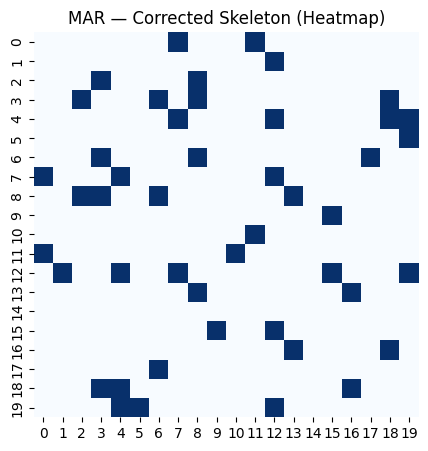

In [209]:
plot_heatmap(res_mar["G_corrected"], "MAR — Corrected Skeleton (Heatmap)")


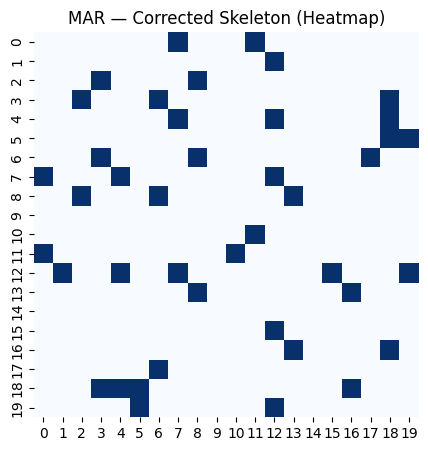

In [210]:
plot_heatmap(res_mnar["G_corrected"], "MAR — Corrected Skeleton (Heatmap)")

In [211]:
# ground truth from your synthetic generator
from data.synthetic_data_generation.synthetic_generator import gen_data

syn = gen_data(num_samples=2000, mode="mar", seed=1)
gt = syn["ground_truth"]

true_ms = gt["m_ind"]
true_prt_ms = gt["parent_m_ind"]
true_prt = {m: p for m, p in zip(true_ms, true_prt_ms)}



In [212]:
est_prt_mar = res_mar["prt_m"]["prt"]
est_prt_mnar = res_mnar["prt_m"]["prt"]


In [213]:
# Simple comparisson

# true: one parent per missingness indicator
true_prt = {m: p for m, p in zip(true_ms, true_prt_ms)}

def evaluate_missingness_parents(true_prt, est_prt):
    rows = []
    for m, true_parent in true_prt.items():
        est = est_prt.get(m, [])
        rows.append({
            "R_ind": m,
            "true_parent": true_parent,
            "estimated_parents": est,
            "correct": true_parent in est
        })
    return rows



In [214]:
# MAR

miss_eval_mar = evaluate_missingness_parents(true_prt, est_prt_mar)
pd.DataFrame(miss_eval_mar)


,R_ind,true_parent,estimated_parents,correct
0,16,7,[13],False
1,5,19,[0],False
2,3,10,[],False
3,15,1,[],False
4,8,18,[],False
5,11,0,[],False


In [215]:
# MNAR

miss_eval_mnar = evaluate_missingness_parents(true_prt, est_prt_mnar)
pd.DataFrame(miss_eval_mnar)



,R_ind,true_parent,estimated_parents,correct
0,16,7,[],False
1,5,19,[],False
2,3,10,[],False
3,15,1,"[4, 5]",False
4,8,18,[10],False
5,11,0,[],False


In [34]:
def evaluate_graph(true_G, est_G):
    tp = np.sum((true_G == 1) & (est_G == 1))
    fp = np.sum((true_G == 0) & (est_G == 1))
    fn = np.sum((true_G == 1) & (est_G == 0))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        "TP": int(tp),
        "FP": int(fp),
        "FN": int(fn),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
    }


In [38]:
eval_skel = evaluate_graph(true_G, G_est)
eval_skel


NameError: name 'true_G' is not defined

In [46]:
# adjacency matrices for true & estimated missingness graphs

p = data_mar.shape[1]   # number of variables

# True missingness graph (parent -> child)
true_missing_G = np.zeros((p, p), dtype=int)
for m, parent in zip(true_ms, true_prt_ms):
    true_missing_G[parent, m] = 1

# Estimated missingness graph from MVPC
est_missing_G_mar = np.zeros((p, p), dtype=int)
for child, parents in est_prt_mar.items():
    for parent in parents:
        est_missing_G_mar[parent, child] = 1

est_missing_G_mnar = np.zeros((p, p), dtype=int)
for child, parents in est_prt_mnar.items():
    for parent in parents:
        est_missing_G_mnar[parent, child] = 1


In [47]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_missingness_graph(true_G, est_G, title="Missingness Graph Comparison"):
    p = true_G.shape[0]
    G_nx = nx.DiGraph()
    G_nx.add_nodes_from(range(p))

    # Add edges with color coding
    for i in range(p):
        for j in range(p):
            if true_G[i, j] == 1 and est_G[i, j] == 1:
                G_nx.add_edge(i, j, color="green", weight=2)   # correct
            elif true_G[i, j] == 0 and est_G[i, j] == 1:
                G_nx.add_edge(i, j, color="red", weight=2)     # false positive
            elif true_G[i, j] == 1 and est_G[i, j] == 0:
                G_nx.add_edge(i, j, color="blue", weight=2)    # missed

    colors = [G_nx[u][v]["color"] for u, v in G_nx.edges()]
    widths = [G_nx[u][v]["weight"] for u, v in G_nx.edges()]

    plt.figure(figsize=(7, 7))
    pos = nx.spring_layout(G_nx, seed=42)
    nx.draw(
        G_nx, pos,
        with_labels=True,
        node_size=800,
        node_color="#EEE",
        font_size=12,
        edge_color=colors,
        width=widths,
        arrowsize=20
    )
    plt.title(title)
    plt.show()


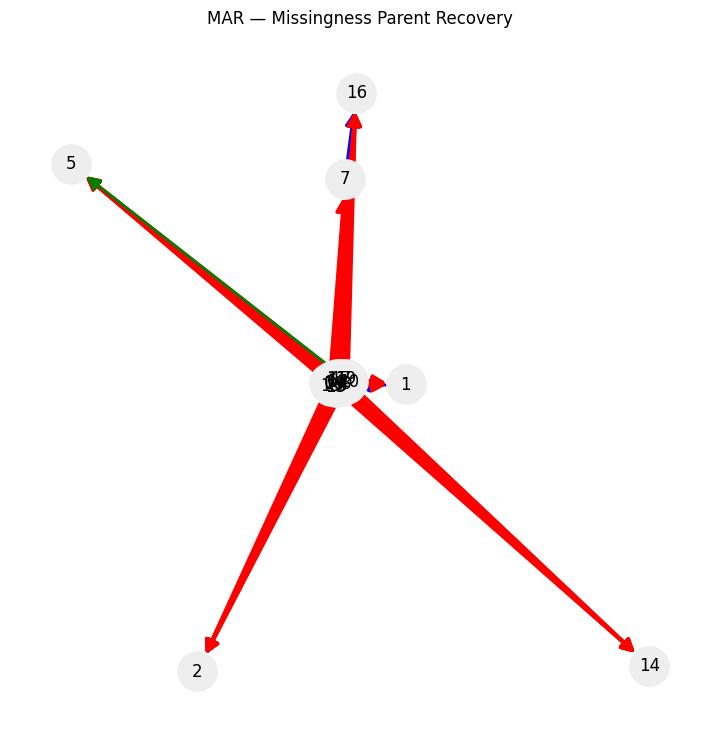

In [48]:
plot_missingness_graph(
    true_missing_G,
    est_missing_G_mar,
    title="MAR — Missingness Parent Recovery"
)


Exception ignored in: <function tqdm.__del__ at 0x000001F1EFC48900>
Traceback (most recent call last):
  File "c:\Users\sofia\OneDrive\Υπολογιστής\Thesis_New\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\sofia\OneDrive\Υπολογιστής\Thesis_New\.venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


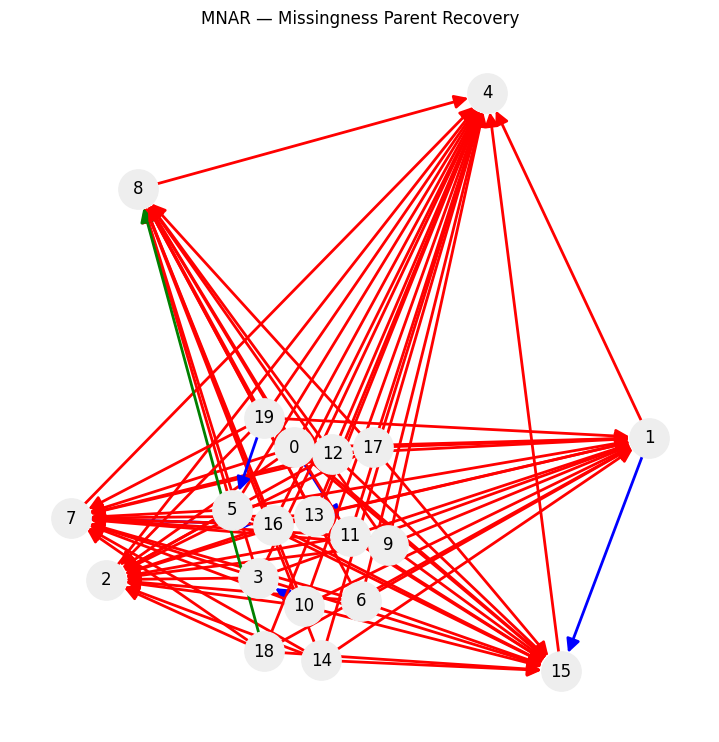

In [49]:
plot_missingness_graph(
    true_missing_G,
    est_missing_G_mnar,
    title="MNAR — Missingness Parent Recovery"
)


In [107]:
from mvpc.ci_tests.bin_td import bin_ci_td  # Add this

mvpc = MVPC(
    indep_test=bin_ci_td,      # ← CHANGE: Binary TD test for PRT
    corr_test=gauss_ci_permc,  # Keep Gaussian for skeleton correction
    alpha=0.05
)


_____________________________________________

# NEW

In [216]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw
from mvpc.missingness import detection_prt_m
from mvpc.skeleton import skeleton2


In [217]:
data_mar = pd.read_csv("../data/synthetic_data_csv_files/missing_mar.csv").values
data_mnar = pd.read_csv("../data/synthetic_data_csv_files/missing_mnar.csv").values

print(data_mar.shape, data_mnar.shape)


(2000, 20) (2000, 20)


In [224]:
# MAR

gt_mar = pd.read_csv("../data/synthetic_data_csv_files/missingness_structure_mar.csv")

# Convert 1‑based → 0‑based
true_ms_mar = (gt_mar["m_ind"]).tolist()
true_prt_ms_mar = (gt_mar["parent_m_ind"]).tolist()

true_prt_mar = {m: p for m, p in zip(true_ms_mar, true_prt_ms_mar)}
true_prt_mar


{2: 8, 7: 4, 1: 15, 5: 0, 16: 13, 14: 11}

In [225]:
# MNAR

gt_mnar = pd.read_csv("../data/synthetic_data_csv_files/missingness_structure_mnar.csv")

true_ms_mnar = (gt_mnar["m_ind"]).tolist()
true_prt_ms_mnar = (gt_mnar["parent_m_ind"]).tolist()

true_prt_mnar = {m: p for m, p in zip(true_ms_mnar, true_prt_ms_mnar)}
true_prt_mnar


{2: 8, 7: 4, 1: 15, 8: 10, 4: 16, 15: 5}

In [220]:
est_prt_mar = res_mar["prt_m"]["prt"]
est_prt_mnar = res_mnar["prt_m"]["prt"]


In [226]:
def evaluate_missingness_parents(true_prt, est_prt):
    rows = []
    for m, true_parent in true_prt.items():
        est = est_prt.get(m, [])
        rows.append({
            "R_ind": m,
            "true_parent": true_parent,
            "estimated_parents": est,
            "correct": true_parent in est
        })
    return pd.DataFrame(rows)


In [227]:
eval_mar = evaluate_missingness_parents(true_prt_mar, est_prt_mar)
eval_mar


,R_ind,true_parent,estimated_parents,correct
0,2,8,[8],True
1,7,4,"[4, 11, 17]",True
2,1,15,[15],True
3,5,0,[0],True
4,16,13,[13],True
5,14,11,"[0, 11]",True


In [228]:
eval_mnar = evaluate_missingness_parents(true_prt_mnar, est_prt_mnar)
eval_mnar


,R_ind,true_parent,estimated_parents,correct
0,2,8,[8],True
1,7,4,"[4, 11]",True
2,1,15,[15],True
3,8,10,[10],True
4,4,16,[16],True
5,15,5,"[4, 5]",True
